In [1]:
%%html
<link rel="stylesheet" type="text/css" href="rise.css" />

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt

# matplotlib configuration
import matplotlib as mpl
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["figure.figsize"] = (12, 6)
# retina display only (e.g. MacOS)
%config InlineBackend.figure_format = 'retina'

# Hidden Markov Models (HMMs) for modeling ion channel dynamics

### An ion channel

<img src="images/COD-scheme.jpg" width="40%">

The macroscopic current recorded from a cell is comprised of the opening and closing dynamics of many ion channels.

<img src="images/single2macro.jpg" width="30%">

A lot of the information on the channel dynamics is lost in the macroscopic current due to averaging over asynchronous events in many different channels.

However, it is possible to record the current through a single ion channel to observe these dynamics, which inform on the conformational changes that the channel undergoes.

<img src="images/single-channel-recording.jpg">

### 2-State (Closed $\rightleftarrows$ Open) HMM for an ion channel

Starting probability in each state:

In [3]:
start = np.array([0.5, 0.5])  # P(C), P(O)

Transition probabilities per time step:

In [4]:
trans = np.array([[0.95, 0.05],   # P(C->C), P(C->O)
                  [0.15, 0.85]])  # P(O->C), P(O->O)

Emission (i.e. ionic current) distributions for each state:

In [5]:
emis = [st.norm(0, 1), st.norm(5, 1)]  # closed, open current distributions

### HMM Simulation

In [6]:
def simulate_hmm(start, trans, emis, n_samples, random_state=0):
    n_states = len(start)
    state_ids = np.arange(n_states, dtype=int)  # 0, 1, ..., n_states-1
    
    # preallocate simulation arrays
    state_seq = np.zeros(n_samples, dtype=int)
    observation_seq = np.zeros(n_samples)
    
    # reset pseudo random number generator
    np.random.seed(random_state)
    
    # randomly assign starting state
    state_seq[0] = np.random.choice(state_ids, p=start)
    
    # randomly assign subsequent states based on the transition probabilities
    for t in range(1, n_samples):
        prev_state = state_seq[t-1]
        state_seq[t] = np.random.choice(state_ids, p=trans[prev_state,:])
    
    # randomly draw state observations from emission distributions
    for state in state_ids:
        mask = (state_seq == state)
        observation_seq[mask] = emis[state].rvs(mask.sum())
    
    return state_seq, observation_seq

Simulate a sequence of 1,000 time steps.

In [7]:
state_seq, current_pA = simulate_hmm(start, trans, emis, 1000)

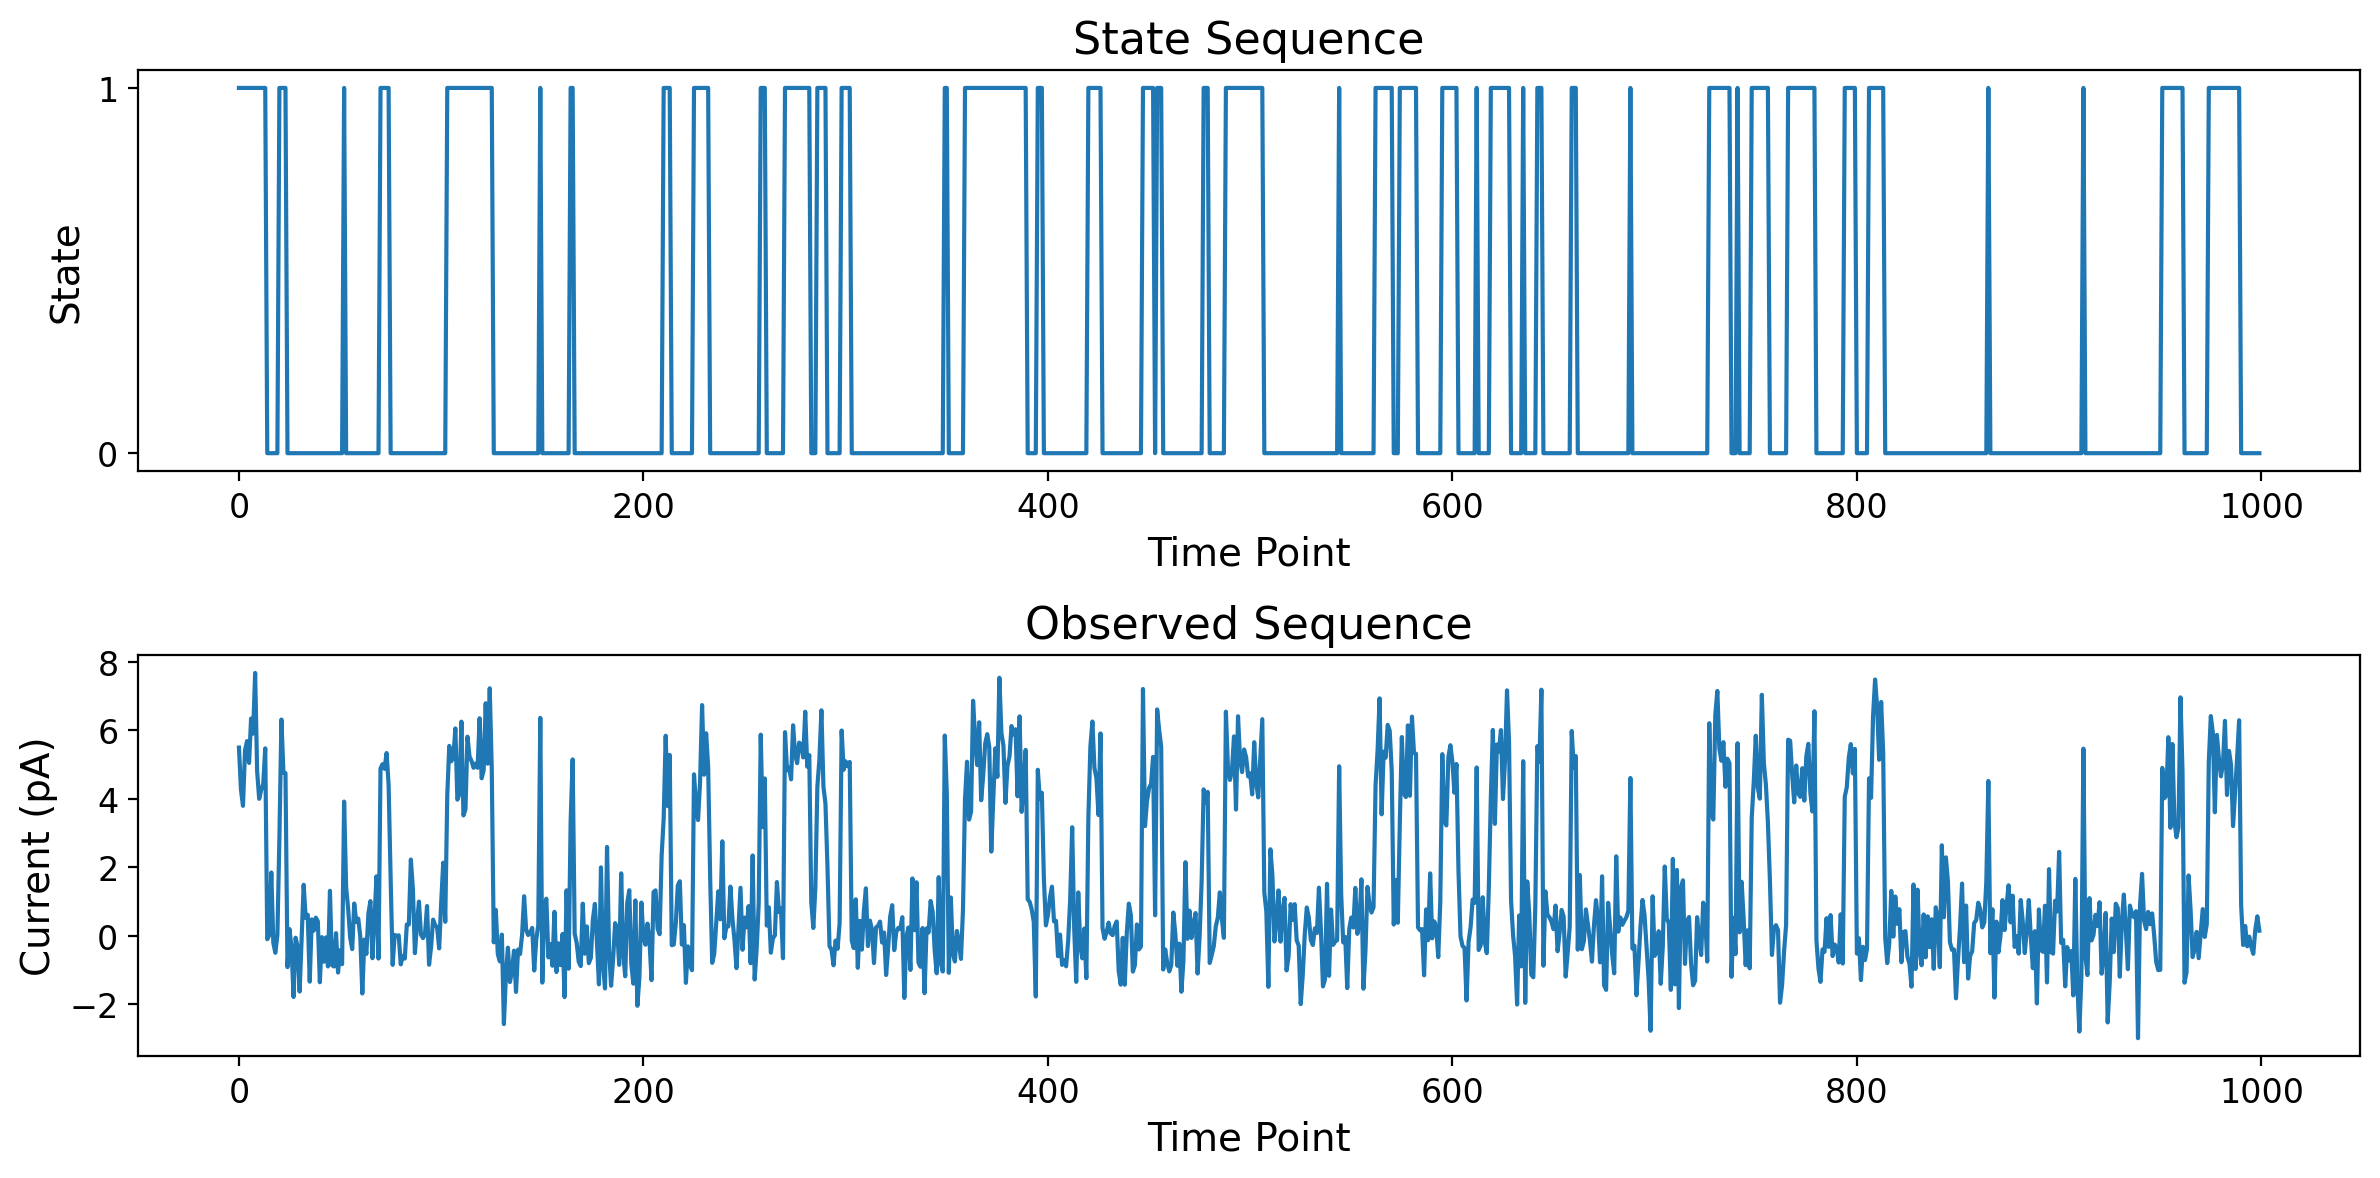

In [8]:
# state and observation sequences
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(state_seq)
plt.yticks(np.unique(state_seq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence')

plt.subplot(2,1,2)
plt.plot(current_pA)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Observed Sequence')
plt.tight_layout();

Now imagine that you recorded the above observation sequence in the lab, but you don't know the underlying state sequence.

You'd like to determine the most likely underlying state sequence that will explain your observed data.

One simple option is to use a threshold to idealize the observations into two states based on the current amplitude at each time point...

In [9]:
threshold = 2.5
predicted_state_seq = np.zeros(current_pA.shape, dtype=int)
predicted_state_seq[current_pA < threshold] = 0
predicted_state_seq[current_pA >= threshold] = 1

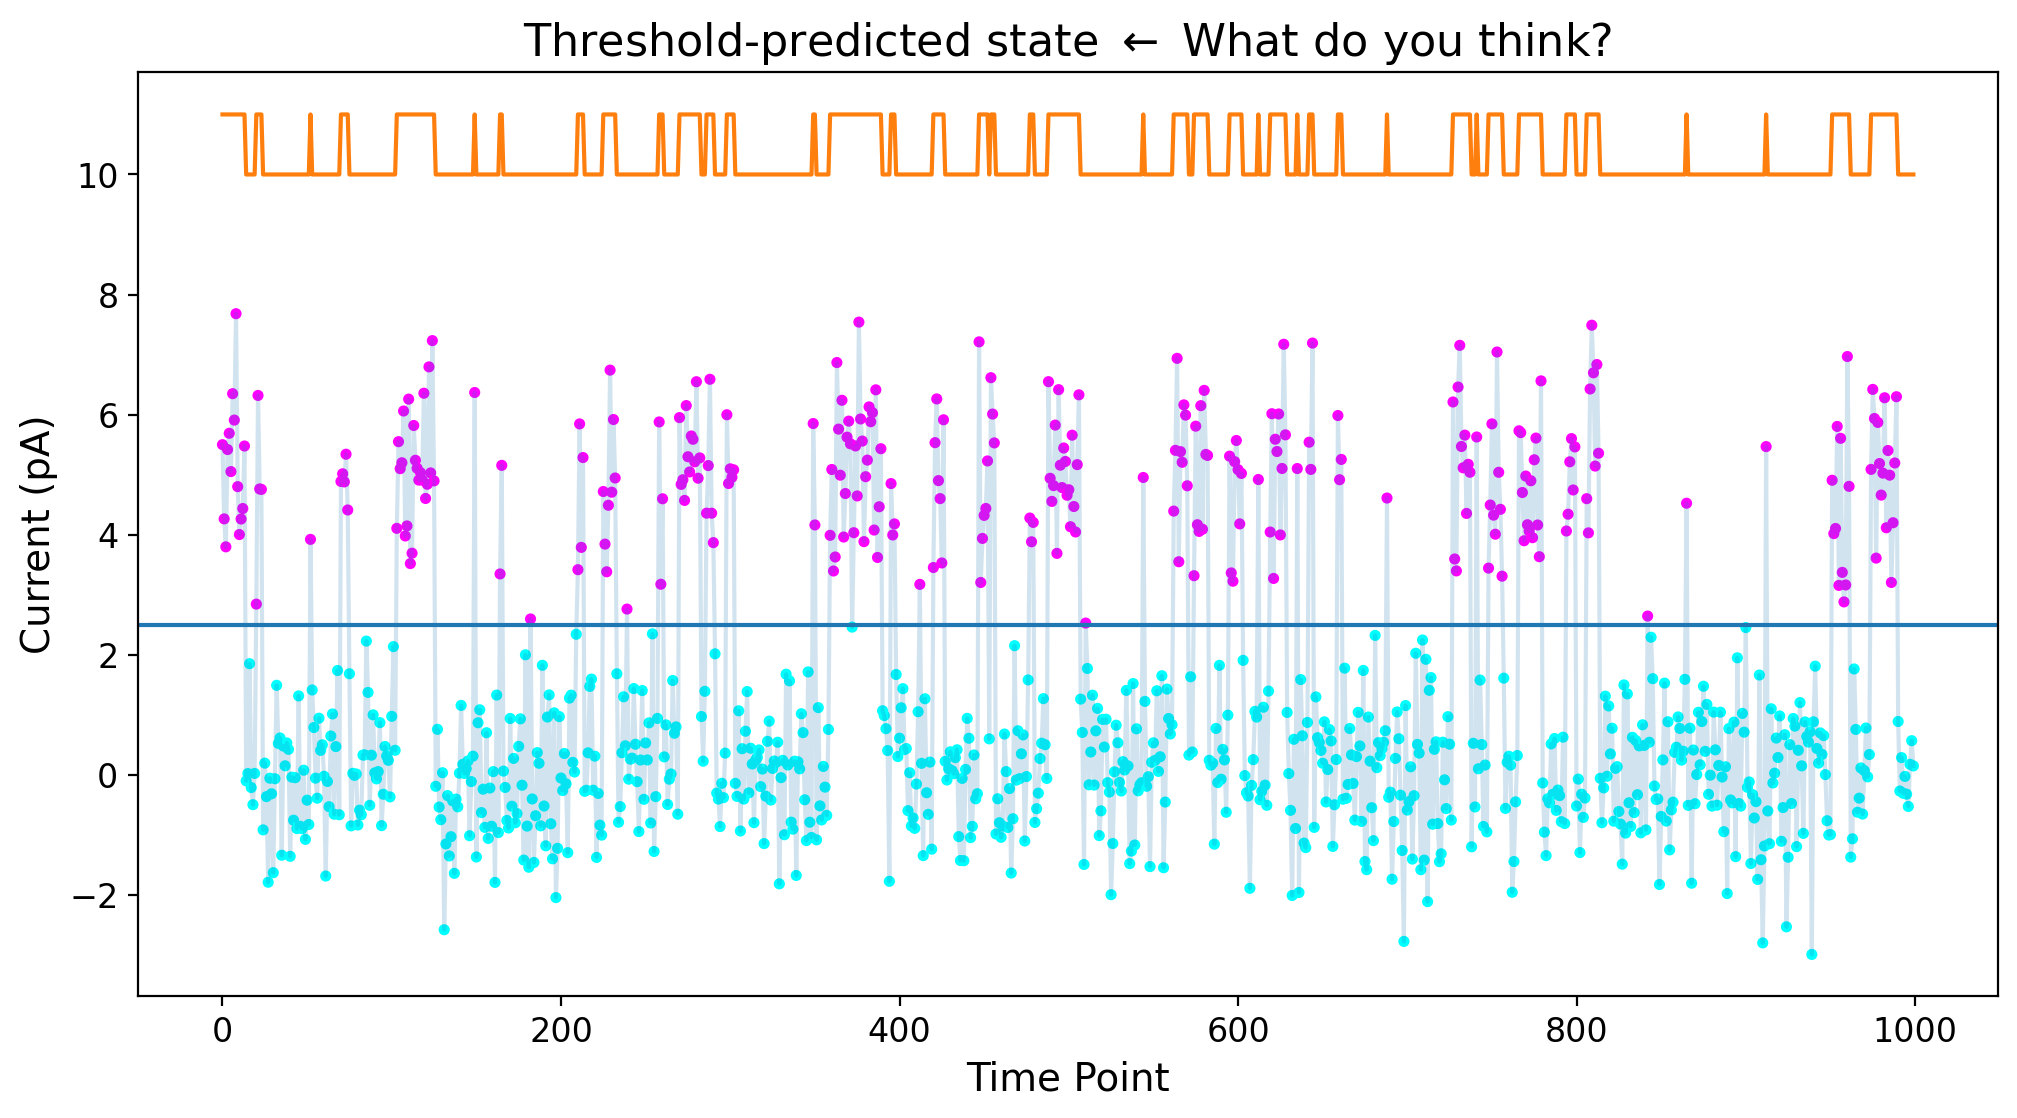

In [10]:
plt.plot(current_pA, alpha=0.2)
plt.scatter(range(len(current_pA)), current_pA, marker='.', c=predicted_state_seq, cmap='cool')
plt.axhline(threshold)
plt.plot(state_seq + 10)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title(r'Threshold-predicted state $\leftarrow$ What do you think?');

How well did thresholding do? Can you think of a case where thresholding won't work well?

Other clustering methods such as GMMs, k-means, etc. can also classify states by amplitude.

We'll explore some of these later in the semester.

### <font color=red> However, amplitude clustering can NOT:</font>

* distinguish states with identical or very similar emissions
* distinguish between a random large noise fluctuation and a transition

### <font color=blue>HMMs can do this.</font>

THey achieve this by taking advantage of the additional information in the sequence of observations rather than just the amplitude of each observation.

### Build a 2-State (Closed $\rightleftarrows$ Open) HMM to explain the observed current sequence.

[Pomegranate](https://pomegranate.readthedocs.io/en/latest/index.html)

```
pip install pomegranate
```

The states...

In [11]:
from pomegranate.distributions import Normal

# Each state emits observations drawn from some distribution.
# Here, we assume that current fluctuations are normally distributed.
C = Normal()  # Closed current distribution
O = Normal()  # Open current distribution

states = [C, O]

The HMM...

In [12]:
from pomegranate.hmm import DenseHMM

hmm = DenseHMM(states)

Reshape the data for input to the HMM...

In [13]:
# [number of sequences, sequence length, dimensions of each data point]
X = current_pA.reshape(1, -1, 1)
X.shape

(1, 1000, 1)

Fit the HMM to our observation sequence...

In [14]:
hmm.fit(X)

DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0-1): 2 x Normal()
  )
)

The HMM predicted hidden state sequence...

In [15]:
predicted_state_seq = hmm.predict(X)
predicted_state_seq

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 0

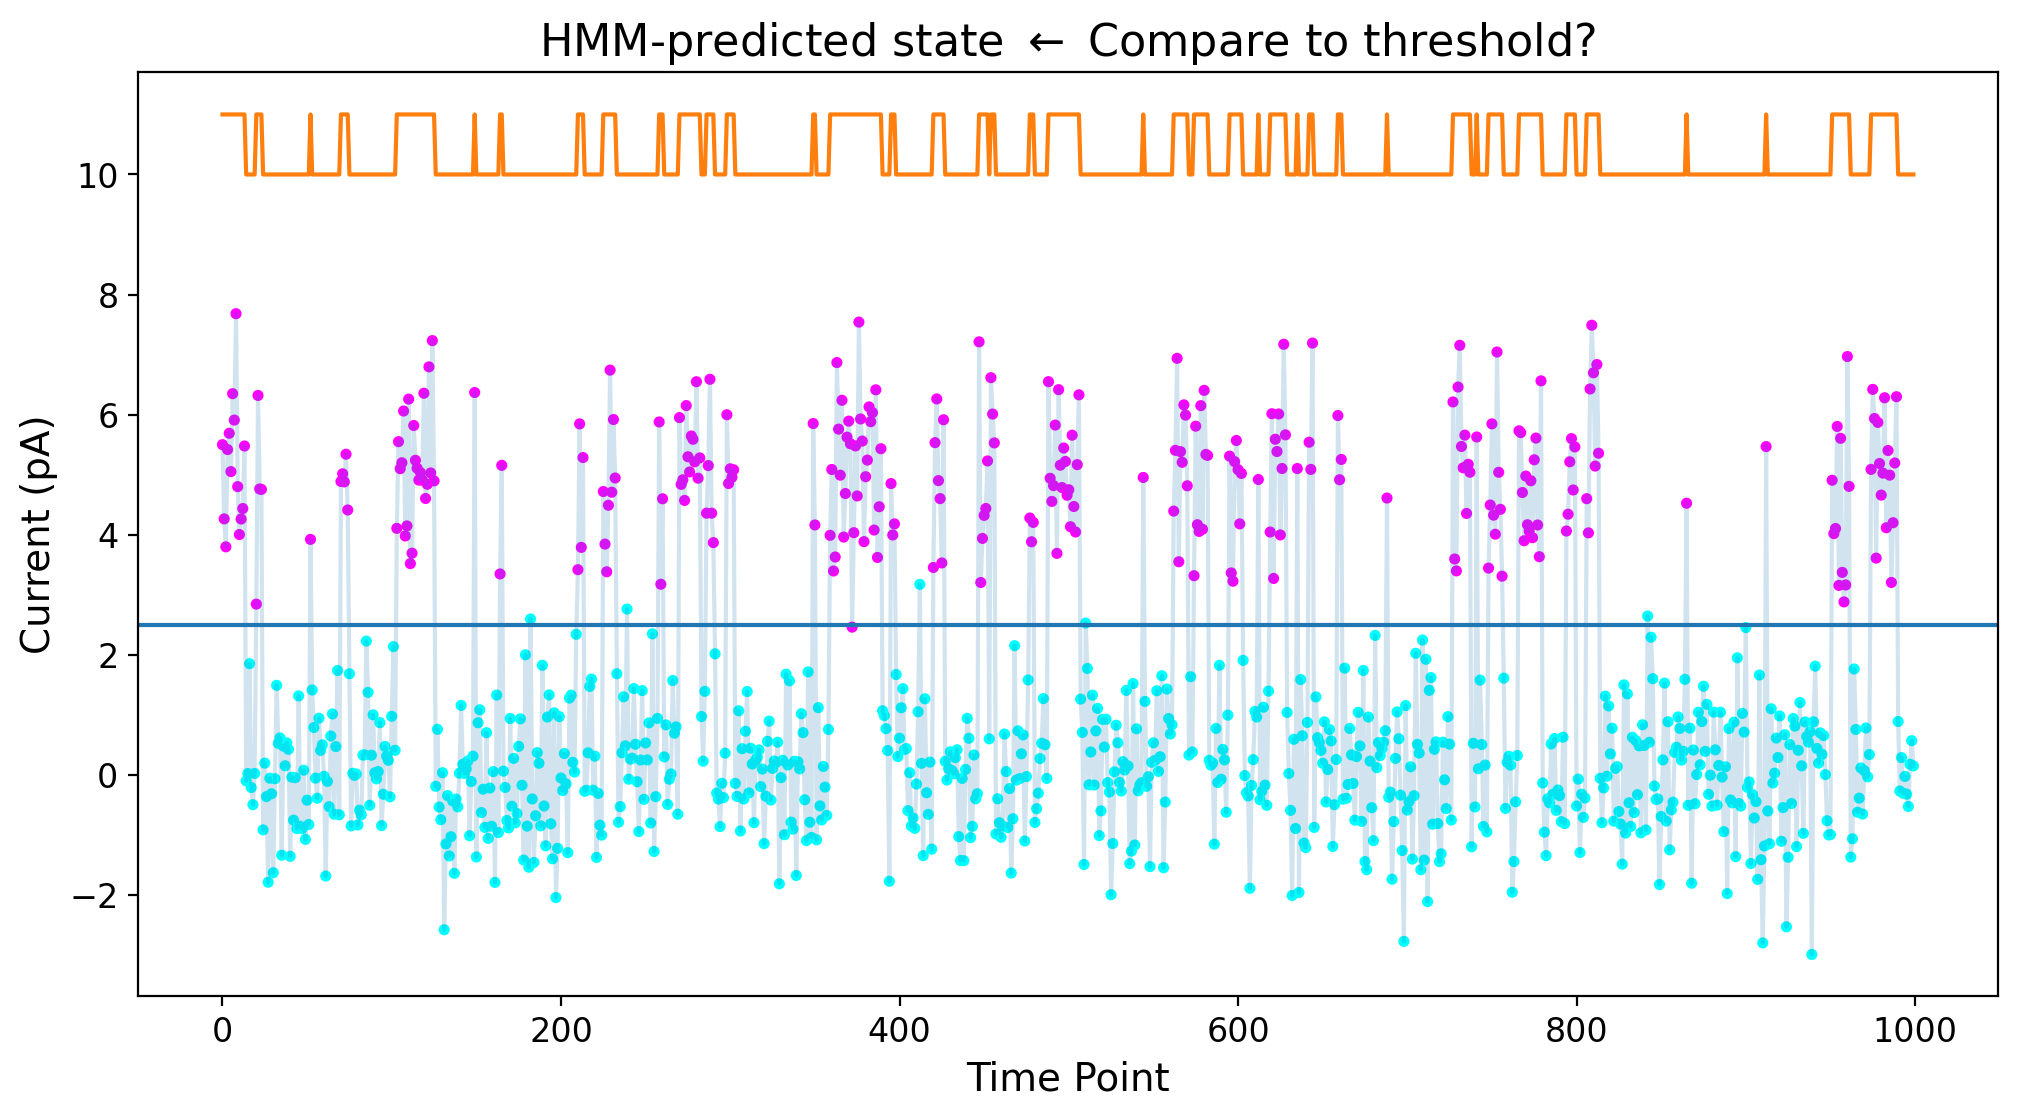

In [16]:
plt.plot(current_pA, alpha=0.2)
plt.scatter(range(len(current_pA)), current_pA, marker='.', c=predicted_state_seq, cmap='cool')
plt.axhline(threshold)
plt.plot(state_seq + 10)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title(r'HMM-predicted state $\leftarrow$ Compare to threshold?');

The starting probabilities...

In [17]:
hmm.starts  # log probabilities

Parameter containing:
tensor([-56.2841,   0.0000])

In [18]:
np.exp(hmm.starts)  # probabilities

tensor([3.5987e-25, 1.0000e+00])

The parameters are **PyTorch Tensor** objects *(you'll see these again when we get to Neural Networks)*. They can easily be converted to **NumPy arrays** if desired.

In [19]:
np.exp(hmm.starts).numpy()

array([3.5986893e-25, 1.0000000e+00], dtype=float32)

The transition probabilities `[from state, to state]`...

In [20]:
hmm.edges  # log probabilities

Parameter containing:
tensor([[-0.0599, -2.8700],
        [-1.9351, -0.1560]])

In [21]:
np.exp(hmm.edges)  # probabilities

tensor([[0.9419, 0.0567],
        [0.1444, 0.8556]])

The state distribution parameters (mean, var)...

In [22]:
# To understand .item() lookup PyTorch Tensor
closed_mean_current = C.means.item()
closed_current_var = C.covs.item()

open_mean_current = O.means.item()
open_current_var = O.covs.item()

closed_current_std = np.sqrt(closed_current_var)
open_current_std = np.sqrt(open_current_var)

print(f'Closed current = {closed_mean_current: 0.3f} +/- {closed_current_std: 0.3f}')
print(f'  Open current = {open_mean_current: 0.3f} +/- {open_current_std: 0.3f}')

Closed current =  0.027 +/-  0.948
  Open current =  5.019 +/-  1.014


The probability that the HMM would ouput the observation sequence...

In [23]:
hmm.probability(X)

tensor([0.])

Zero!?

In [24]:
hmm.probability(X[:,:10])  # less points

tensor([3.8777e-17])

Recall that the probability of the entire sequence is the product of many probabilities, most of which are less than one.

This product can quickly get smaller than the smallest floating point number your computer can represent (numerical underflow).

Recall, we had this same issue when computing maximum likelihood.

To avoid this issue, we used log(probability) instead becase the log of a product of small probabilities is the sum of their logs, which is much less likely to underflow.

In [25]:
hmm.log_probability(X)

tensor([-1661.7638])

This value is not very meaningful on its own as it will depend not only on the goodness of fit, but also on the length of the sequence.

However, we can use it to compare with other models for this particular sequence.

Just so you can see that fitting the model to the observation sequence results in model parameters that make the sequence more likely...

In [26]:
# before optimization
hmm = DenseHMM(states)
hmm.log_probability(X)

tensor([-2063.1755])

In [27]:
# after optimization
hmm.fit(X)
hmm.log_probability(X)

tensor([-1661.7692])

### 3-State (Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized) HMM for an ion channel

Starting probability in each state:

In [28]:
start = np.array([1, 0, 0])  # P(C), P(O), P(D)

Transition probabilities per time step:

In [29]:
# !!! Note that C->D and D->C are disallowed.

trans = np.array([[0.950, 0.050, 0.000],   # P(C->C), P(C->O), P(C->D)
                  [0.030, 0.950, 0.020],   # P(O->C), P(O->O), P(O->D)
                  [0.000, 0.004, 0.996]])  # P(D->C), P(D->O), P(D->D)

Emission (i.e. ionic current) distributions for each state:

In [30]:
emis = [st.norm(0, 1), st.norm(5, 1.2), st.norm(0, 1)]

Simulate a sequence of 100,000 time steps.

In [31]:
state_seq, current_pA = simulate_hmm(start, trans, emis, 10000)

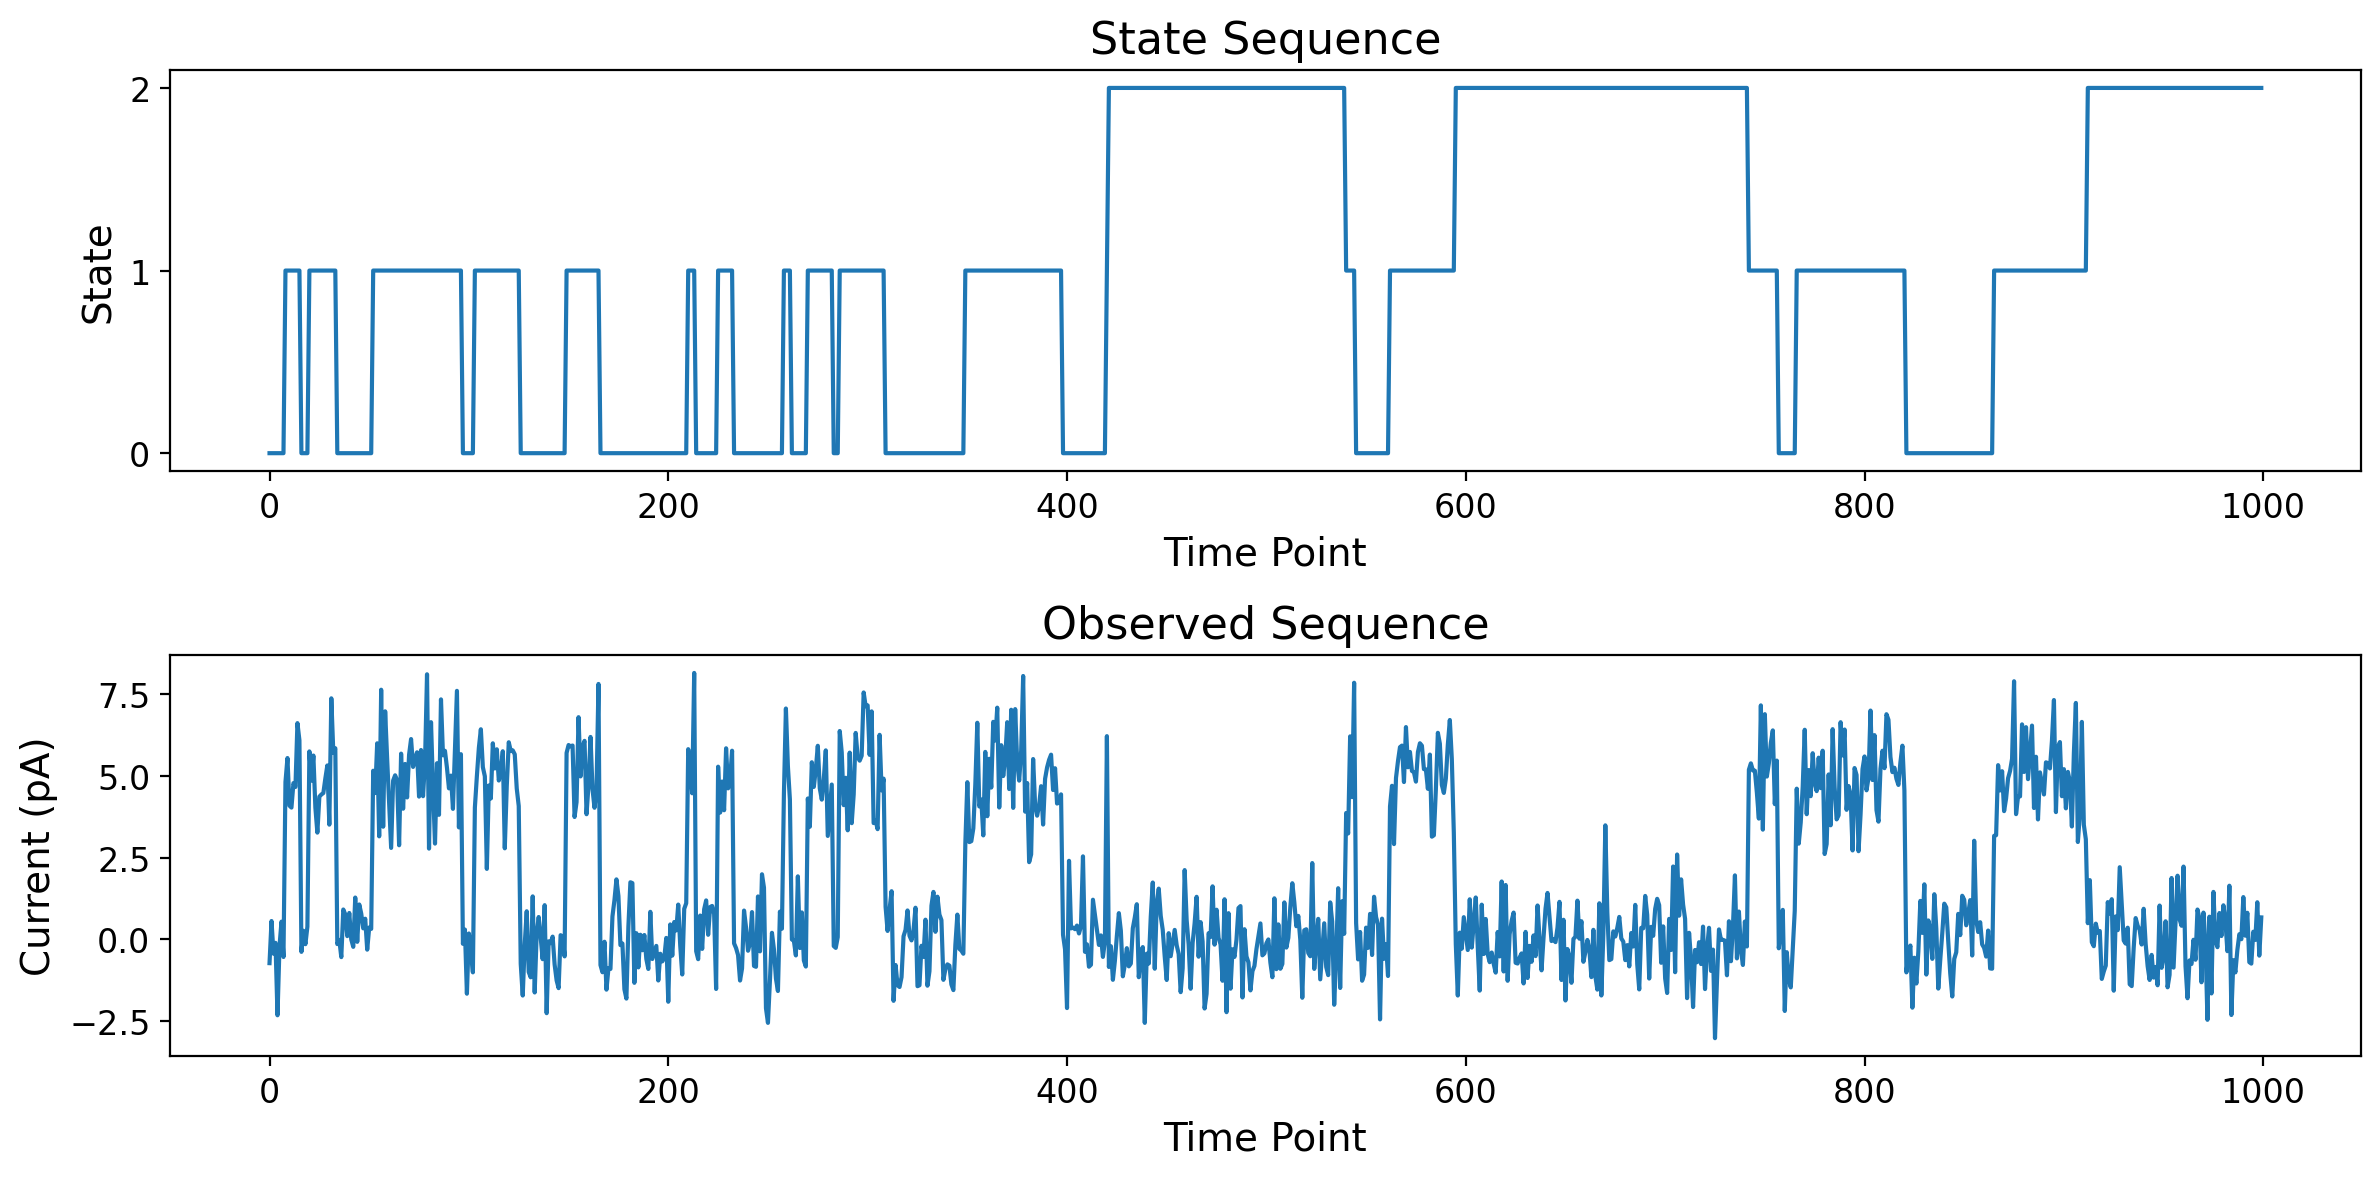

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(state_seq[:1000])
plt.yticks(np.unique(state_seq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence')

plt.subplot(2,1,2)
plt.plot(current_pA[:1000])
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Observed Sequence')
plt.tight_layout();

Now imagine that you recorded the above observation sequence in the lab, but you don't know the underlying state sequence.

You'd like to determine the most likely underlying state sequence that will explain your observed data.

There are only two obvious current levels in the data, so why would you use anything other than a Closed $\rightleftarrows$ Open HMM?

1. You know something about the system that suggests more than two states.
2. The dynamics of the observations are inconsistent with only two states (e.g., both short and long closures).

<img src="images/COD-scheme.jpg" width="40%">

### Build a 3-State (Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized) HMM to explain the observed current sequence.

In [33]:
C = Normal()  # Closed current distribution
O = Normal()  # Open current distribution
D = Normal()  # Desensitized current distribution

states = [C, O, D]

hmm = DenseHMM(states)

Fit the HMM to our observation sequence...

In [35]:
# [number of sequences, sequence length, dimensions of each data point]
X = current_pA.reshape(1, -1, 1)

hmm.fit(X)

DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0-2): 3 x Normal()
  )
)

The HMM predicted hidden state sequence...

In [36]:
predicted_state_seq = hmm.predict(X)

predicted_state_seq.unique()

tensor([0, 1, 2])

In [37]:
predicted_state_seq.size()

torch.Size([1, 10000])

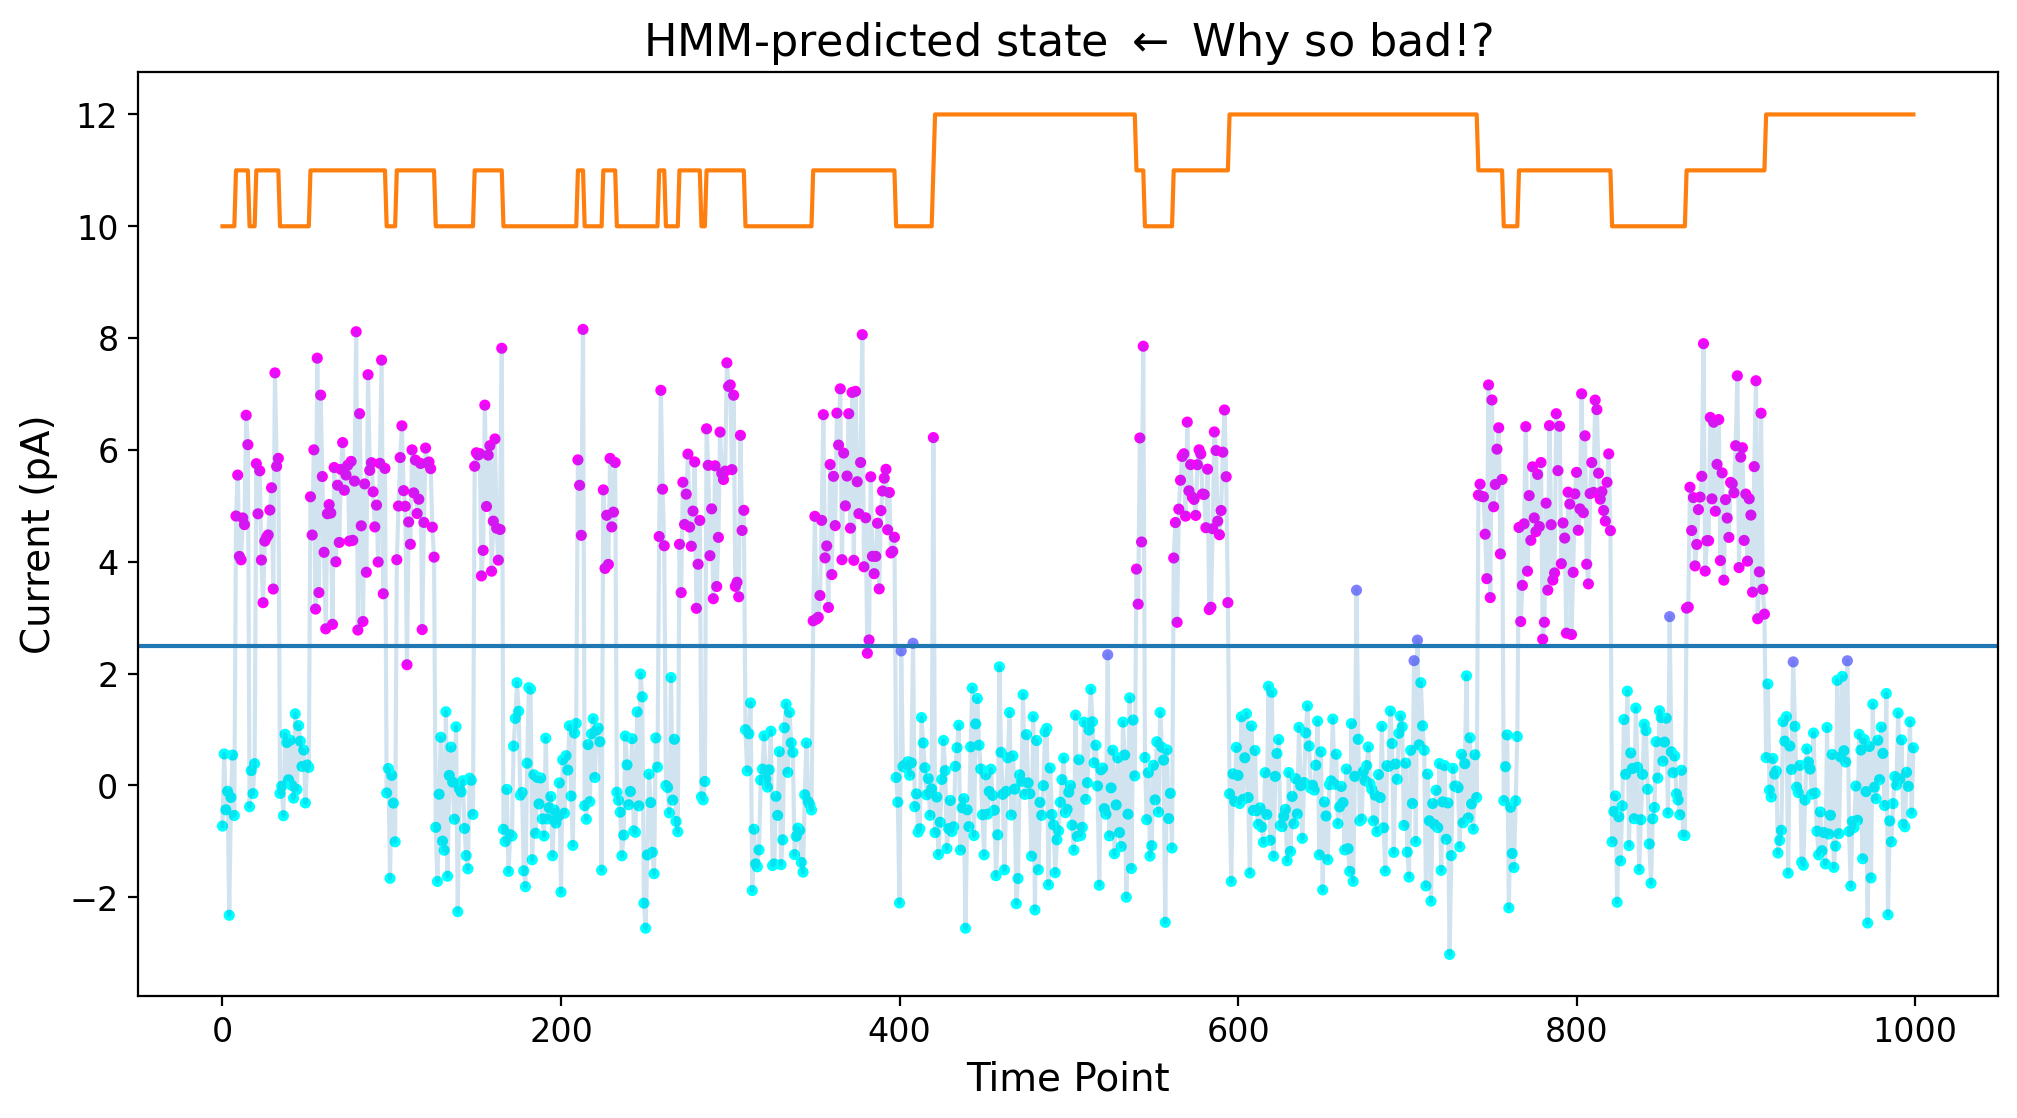

In [38]:
plt.plot(current_pA[:1000], alpha=0.2)
plt.scatter(range(1000), current_pA[:1000], marker='.', c=predicted_state_seq[0,:1000], cmap='cool')
plt.axhline(threshold)
plt.plot(state_seq[:1000] + 10)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title(r'HMM-predicted state $\leftarrow$ Why so bad!?');

During optimization some of the states were assigned to the wrong current level.

In [39]:
for state in [C, O, D]:
    print(state.means.item())

-0.13437098264694214
0.9346914291381836
5.0297112464904785


The optimized HMM allows transitions between all states.

In [40]:
np.exp(hmm.edges)

tensor([[8.7083e-01, 1.1412e-01, 1.5057e-02],
        [8.4159e-01, 1.5267e-01, 4.8032e-03],
        [5.3850e-02, 9.0597e-04, 9.4524e-01]])

But if we want a Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized model, then we should disallow transitions between C and D states.

For the previous Closed $\rightleftarrows$ Open model, the model was so simple that it was not necessary to define any of the parameters before fitting to the observation sequence.

However, for more complex models, the fit result can depend heavily on the initial parameters. Thus, you may want to specify reasonable starting parameters before fitting.

Let's initialize the HMM so that transitions between C and D states are disallowed and so that the O state has non-zero mean current amplitude.

In [41]:
C = Normal(means=[0.0], covs=[[1.0]])  # Closed current mean=0, var=1
O = Normal(means=[7.0], covs=[[1.0]])  # Open current mean=7, var=1
D = Normal(means=[0.0], covs=[[1.0]])  # Desensitized current mean=0, var=1

states = [C, O, D]

# start in the closed state
starts = [1.0, 0.0, 0.0]

# transition probabilities between each state
# !!! C->D and D->C are zero --> these transitions are disallowed
# The rest of the transition probabilities are not too important,
# just give them something remotely resonable and let the optimization figure them out.
edges = [
    [0.90, 0.10, 0.00],  # C->C, C->O, C->D
    [0.05, 0.90, 0.05],  # O->C, O->O, O->D
    [0.00, 0.01, 0.99],  # D->C, D->O, D->D
]

hmm = DenseHMM(states, starts=starts, edges=edges)

Now fit the initialized model with C->D and D->C transitions disallowed to the observation sequence.

In [42]:
hmm.fit(X)

DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0-2): 3 x Normal()
  )
)

Note that the C->D and D->C transition probabilities are still zero!

In contrast, all other transitions were optimized based on the observation sequence.

In [43]:
np.exp(hmm.edges)

tensor([[0.9421, 0.0579, 0.0000],
        [0.0357, 0.9444, 0.0199],
        [0.0000, 0.0055, 0.9943]])

Also, the states are correctly assigned to the current levels.

In [44]:
for state in [C, O, D]:
    print(state.means.item())

-0.10846024006605148
5.0312371253967285
0.011410107836127281


The new HMM predicted hidden state sequence...

In [45]:
predicted_state_seq = hmm.predict(X)

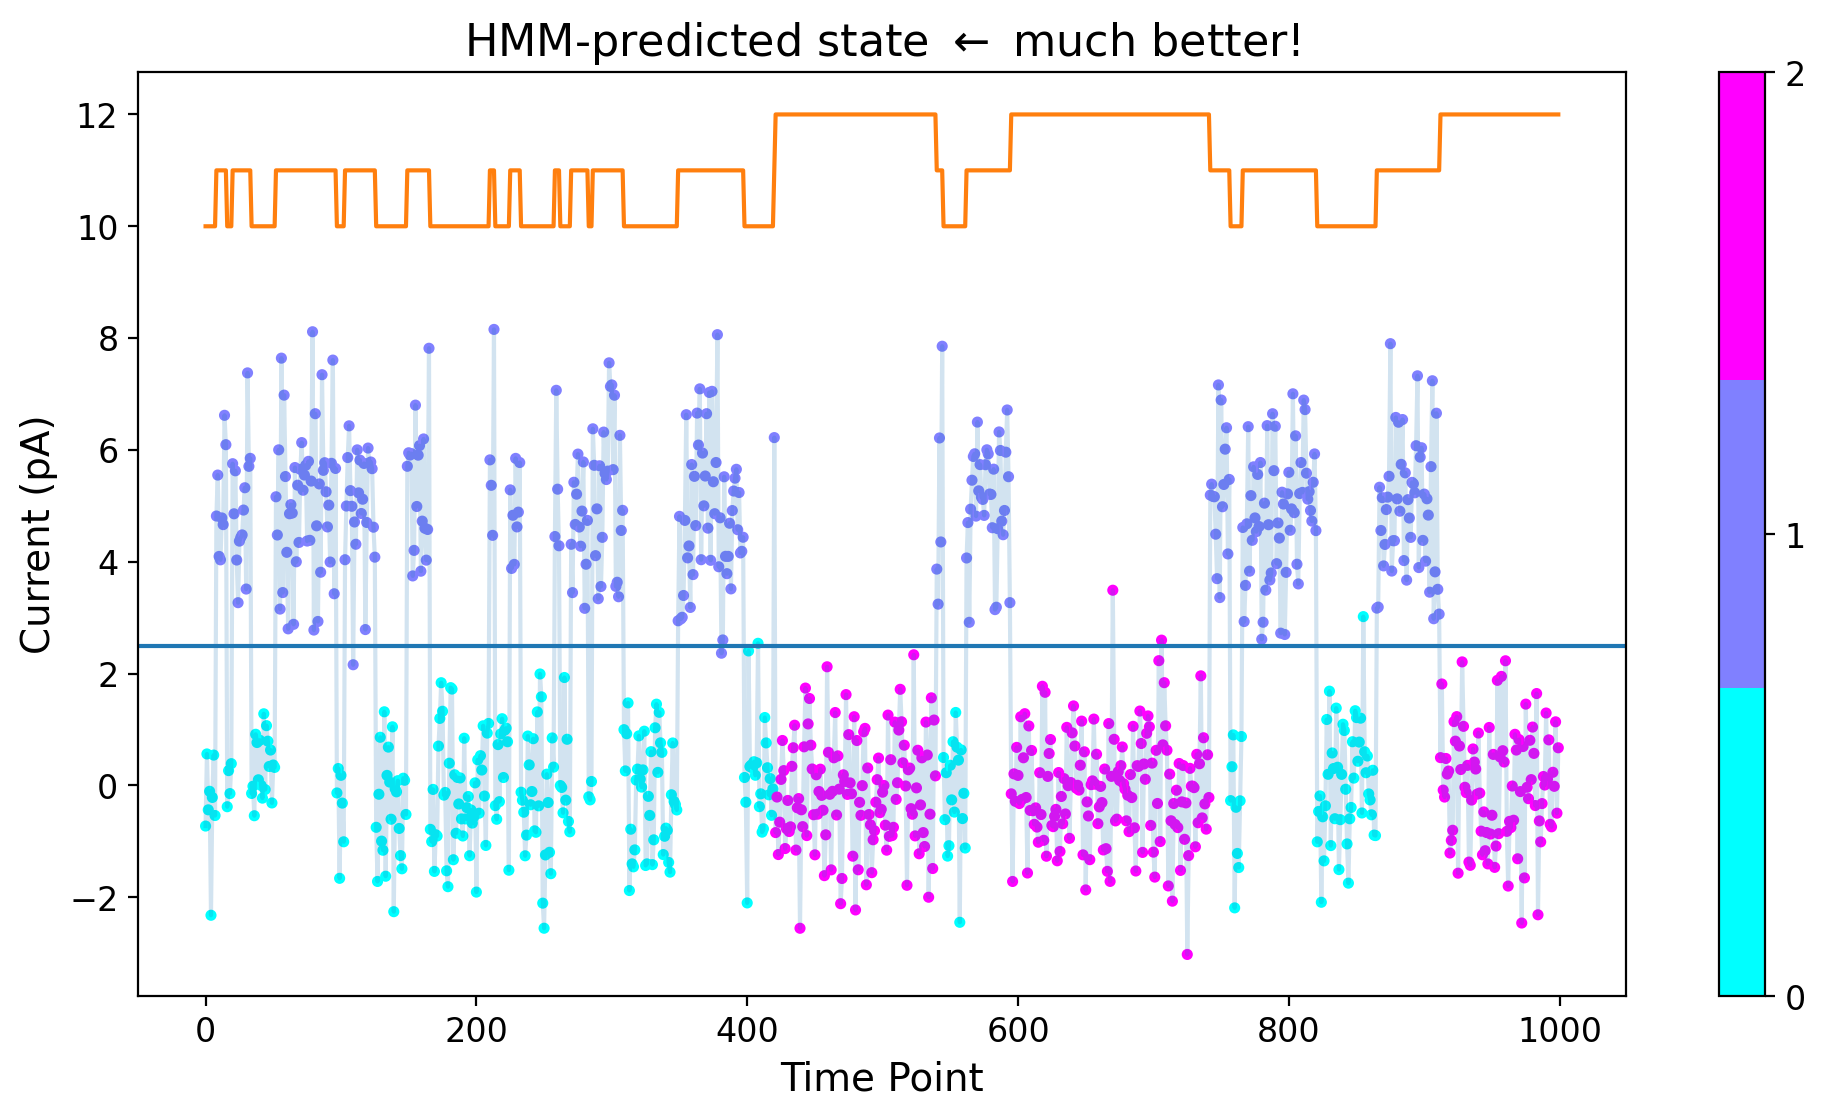

In [46]:
n = 1000
plt.plot(current_pA[:n], alpha=0.2)
cmap = mpl.colormaps['cool'].resampled(3)
plt.scatter(range(n), current_pA[:n], marker='.', c=predicted_state_seq[0,:n], cmap=cmap)
plt.axhline(threshold)
plt.plot(state_seq[:n] + 10)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title(r'HMM-predicted state $\leftarrow$ much better!')
plt.colorbar(ticks=[0, 1, 2]);

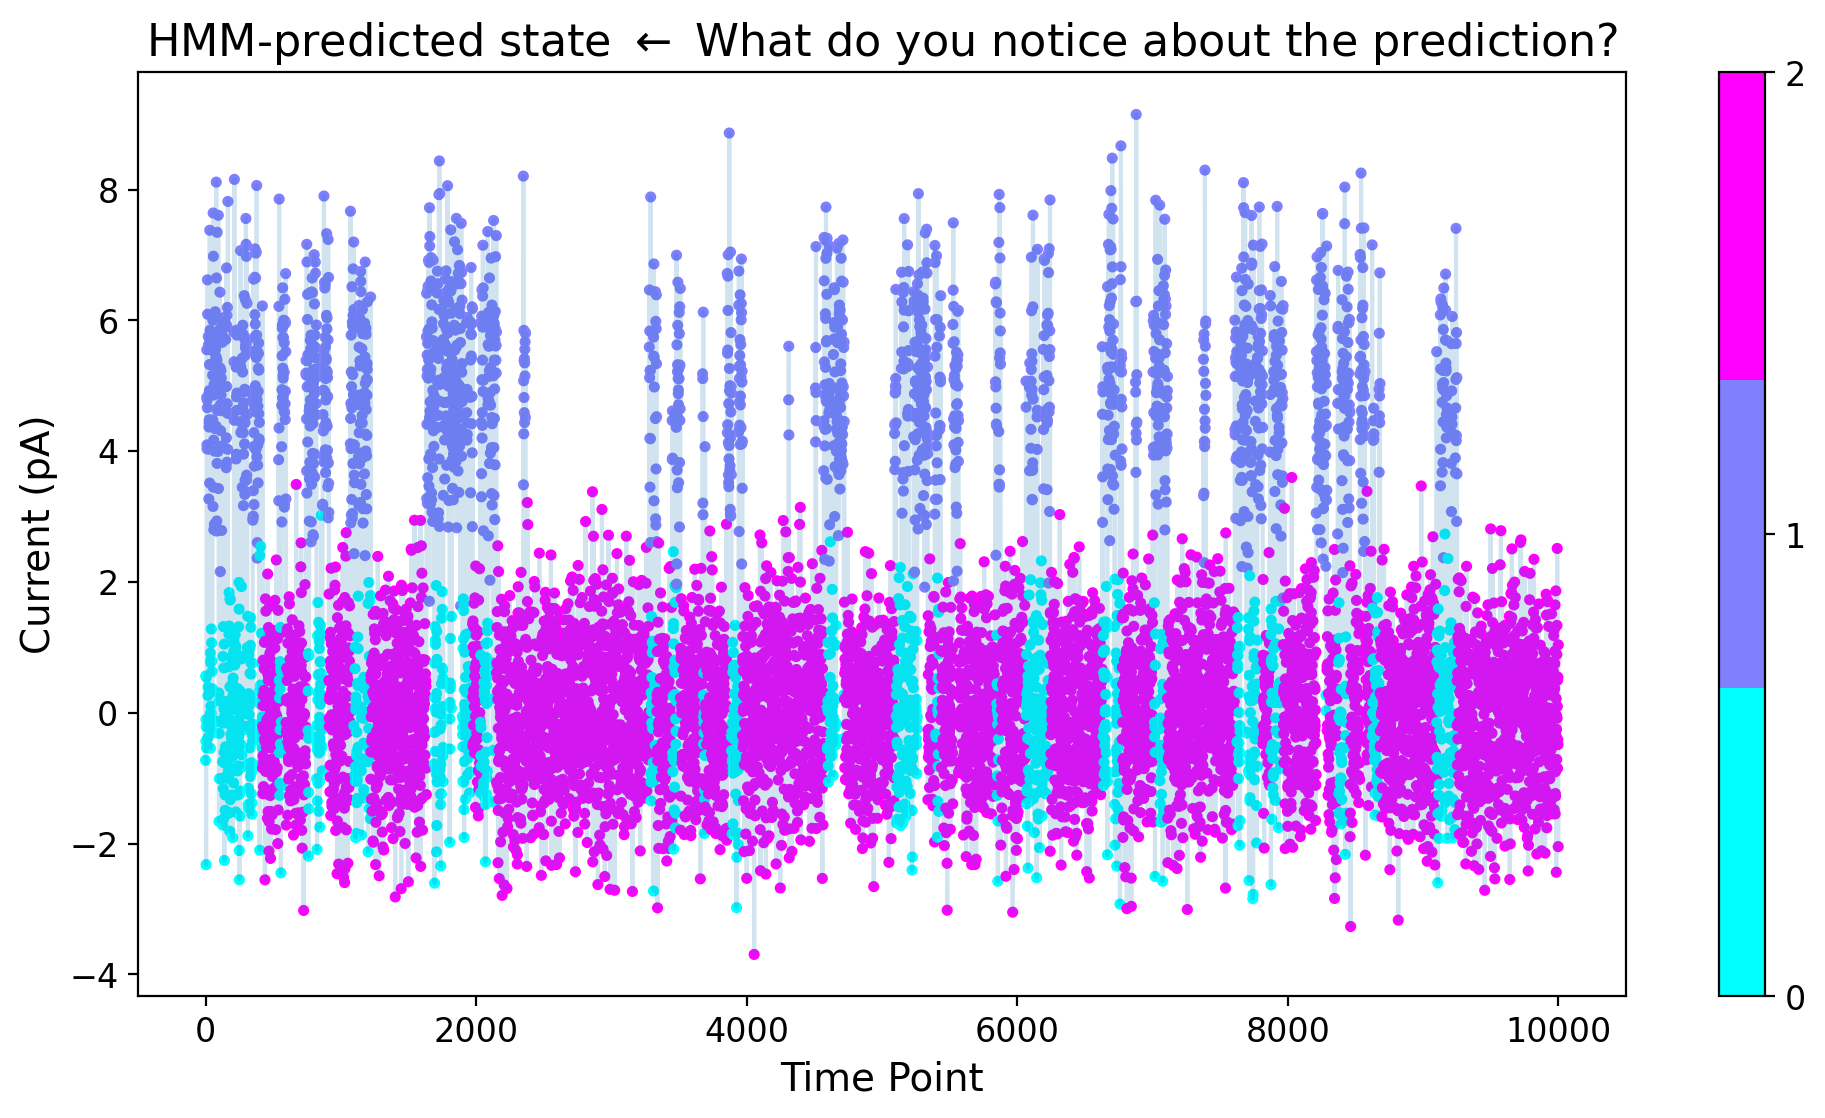

In [47]:
n = 10000
plt.plot(current_pA[:n], alpha=0.2)
plt.scatter(range(n), current_pA[:n], marker='.', c=predicted_state_seq[0,:n], cmap=cmap)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title(r'HMM-predicted state $\leftarrow$ What do you notice about the prediction?')
plt.colorbar(ticks=[0, 1, 2]);

Predicted state probabilities at each time step.

In [48]:
predicted_state_proba = hmm.predict_proba(X)
predicted_state_proba.shape

torch.Size([1, 10000, 3])

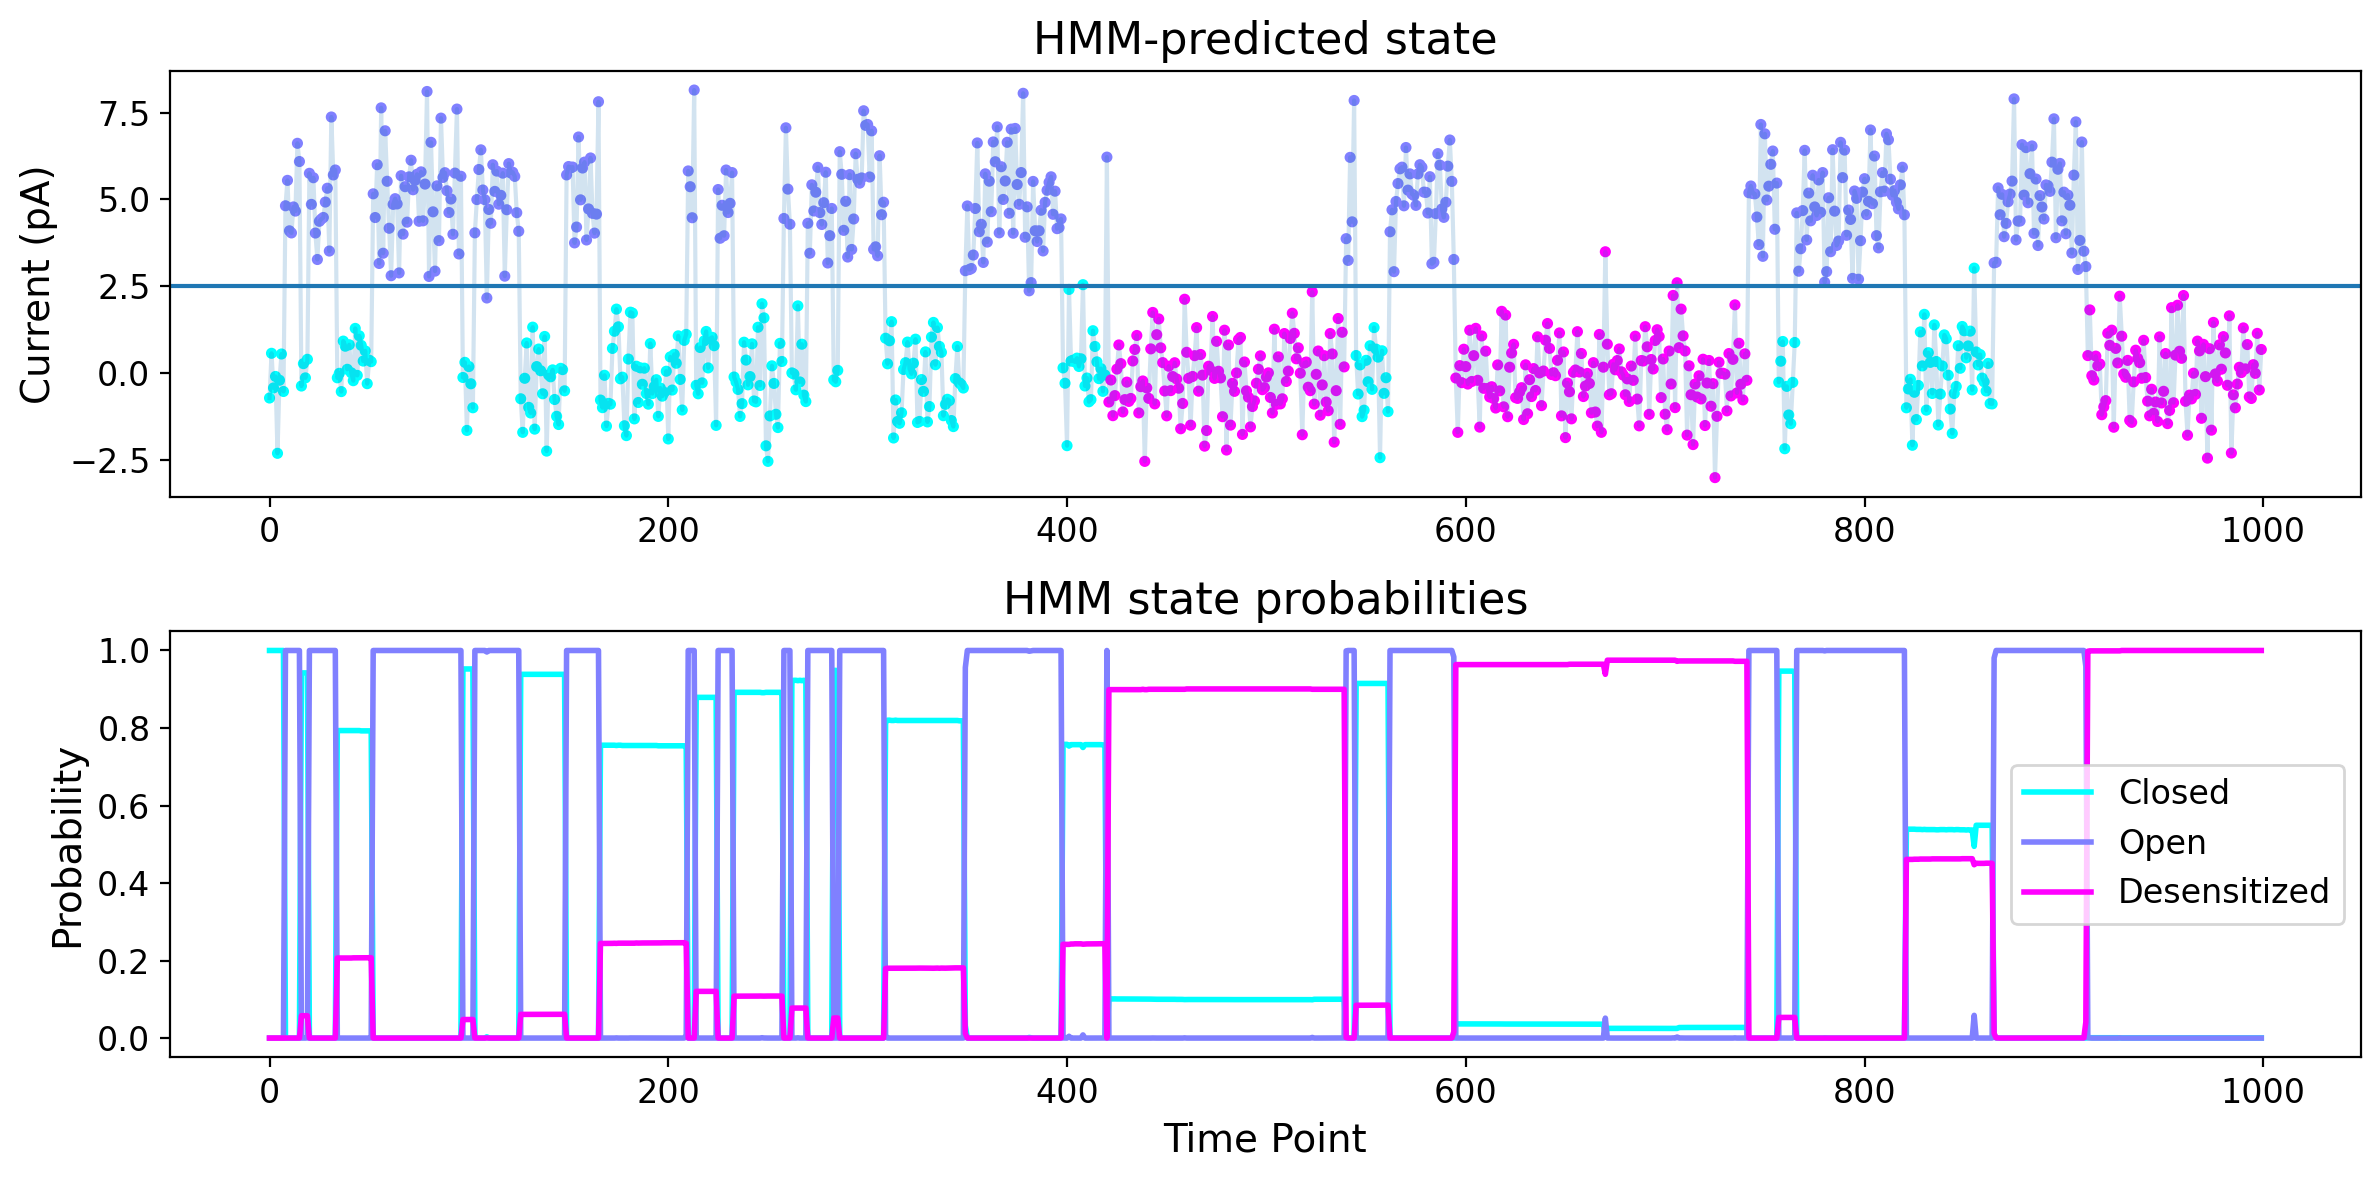

In [49]:
n = 1000
plt.subplot(2, 1, 1)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predicted_state_seq[0,:n], cmap=cmap)
plt.ylabel('Current (pA)')
plt.title('HMM-predicted state')

plt.subplot(2, 1, 2)
for i in range(3):
    plt.plot(predicted_state_proba[0,:n,i], lw=2, color=cmap(i))
plt.xlabel('Time Point')
plt.ylabel('Probability')
plt.title('HMM state probabilities')
plt.legend(['Closed', 'Open', 'Desensitized'])
plt.tight_layout();

### Filtering and Missed Events
I just want to quickly point out how filtering can affect single molecule event data, as this will be an important consideration when preprocessing such data before fitting an HMM.

In [50]:
dt_ms = 0.1  # sample interval
fs_kHz = 1 / dt_ms  # sample frequency
time_ms = np.arange(len(current_pA)) * dt_ms

time_ms.shape, current_pA.shape

((10000,), (10000,))

Lowpass filter at 1 or 2 kHz.

In [51]:
from scipy import signal

lowpass2kHz = signal.firwin(301, 2, fs=fs_kHz)
lowpass1kHz = signal.firwin(301, 1, fs=fs_kHz)

filtered2kHz = np.convolve(current_pA, lowpass2kHz, 'same')
filtered1kHz = np.convolve(current_pA, lowpass1kHz, 'same')

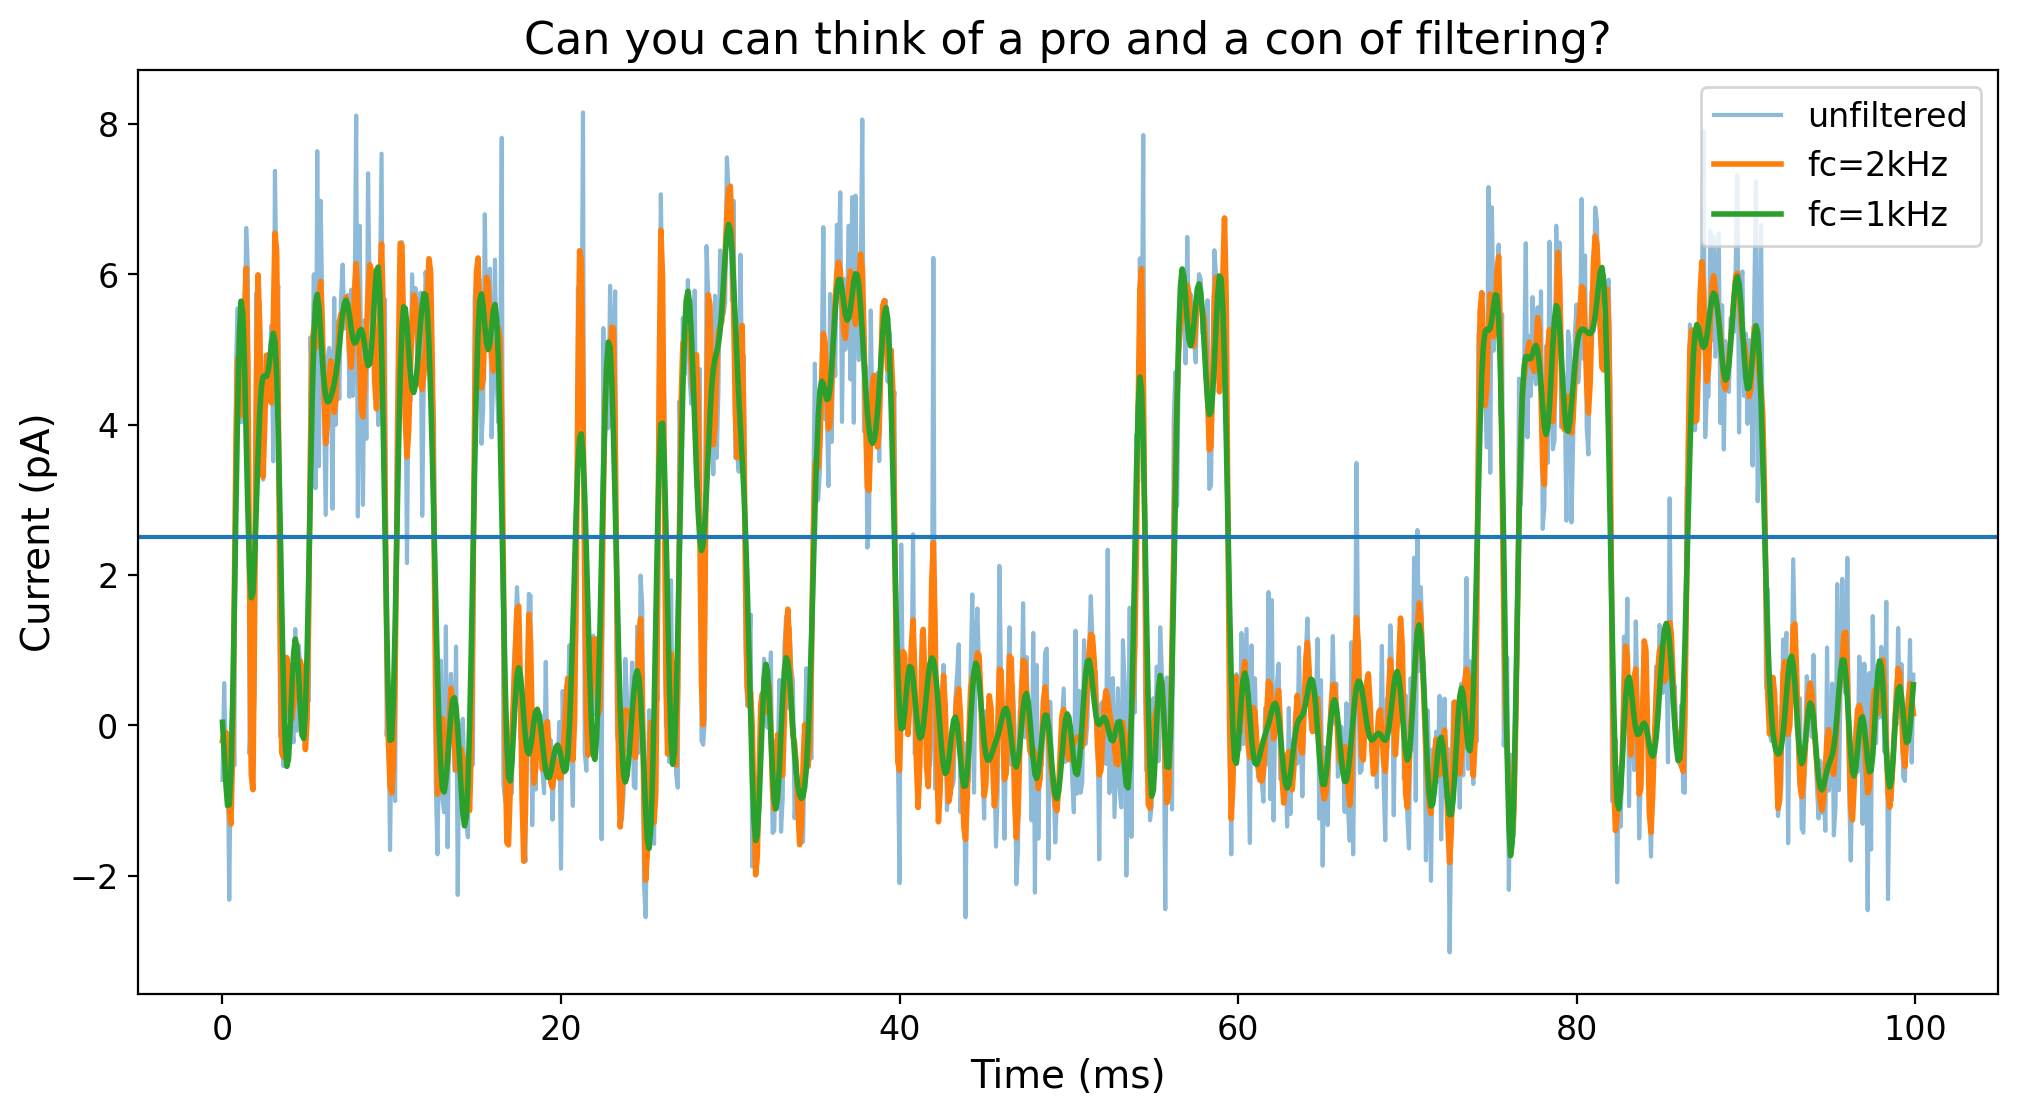

In [52]:
n = 1000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5, label='unfiltered')
plt.plot(time_ms[:n], filtered2kHz[:n], lw=2, label='fc=2kHz')
plt.plot(time_ms[:n], filtered1kHz[:n], lw=2, label='fc=1kHz')
plt.axhline(threshold)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Can you can think of a pro and a con of filtering?')
plt.legend(loc='upper right');

### Dwell Time Distributions

Examination of these distributions can suggest how many states at each emission level you should include in your model.

In [53]:
# We need a bunch more events to get good looking dwell time distributions,
# so I'm going to simulate a lot more data just so you can see what
# these distributions look like.
long_state_seq, long_current_pA = simulate_hmm(start, trans, emis, 1000000)

In [54]:
dwell_times = {}
for i in np.unique(long_state_seq):
    dwell_times[i] = []
for i, state in enumerate(long_state_seq):
    if i > 0 and long_state_seq[i-1] == state:
        dwell_times[state][-1] += 1
    else:
        dwell_times[state].append(1)

closed_times = dwell_times[0] + dwell_times[2]
open_times = dwell_times[1]

dt_ms = 0.1
closed_times_ms = np.array(closed_times) * dt_ms
open_times_ms = np.array(open_times) * dt_ms

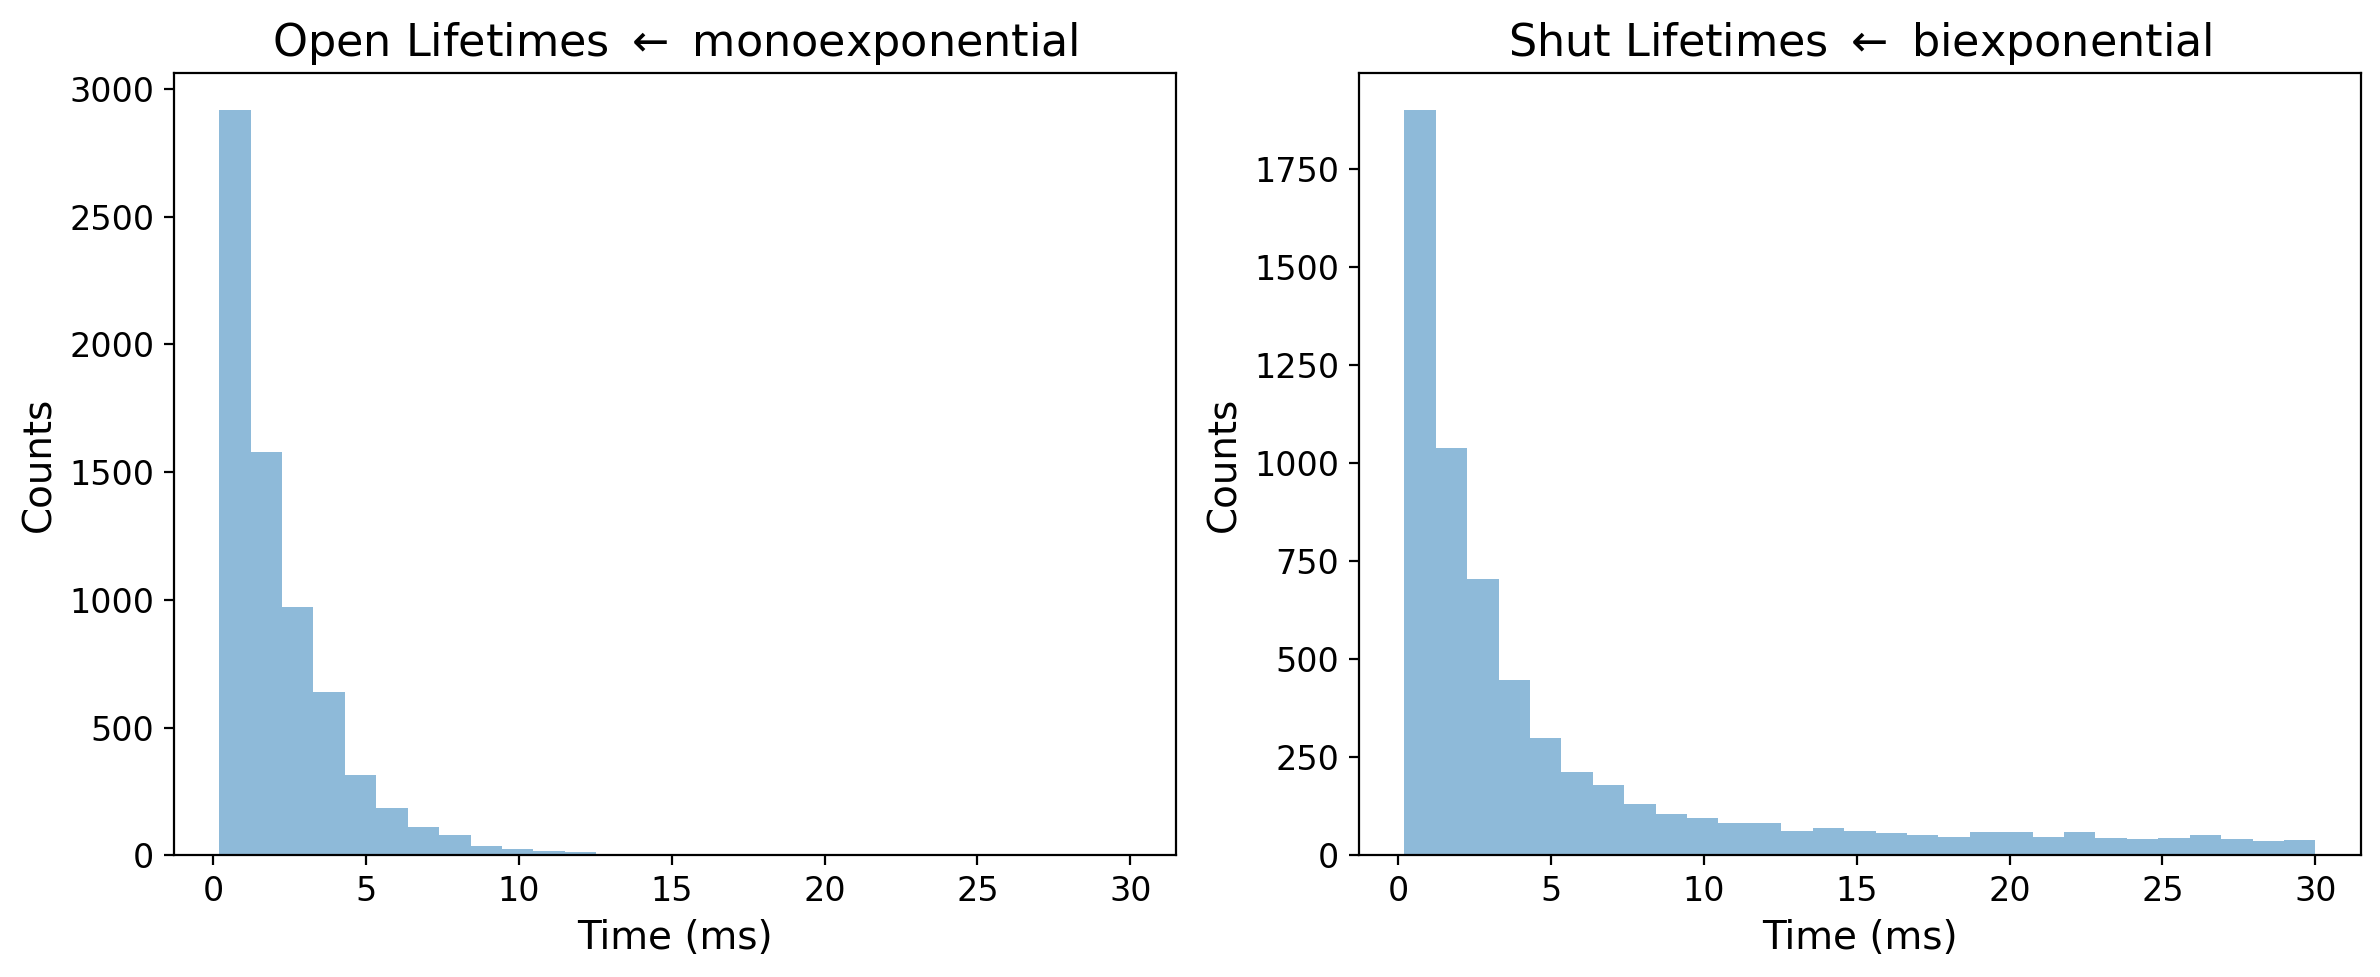

In [55]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)
binedges = np.linspace(0.2, 30, 30)
plt.hist(open_times_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title(r'Open Lifetimes $\leftarrow$ monoexponential')

plt.subplot(1, 2, 2)
binedges = np.linspace(0.2, 30, 30)
plt.hist(closed_times_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title(r'Shut Lifetimes $\leftarrow$ biexponential')
plt.tight_layout();

Dwelltimes are often binned and plotted on a logscale.

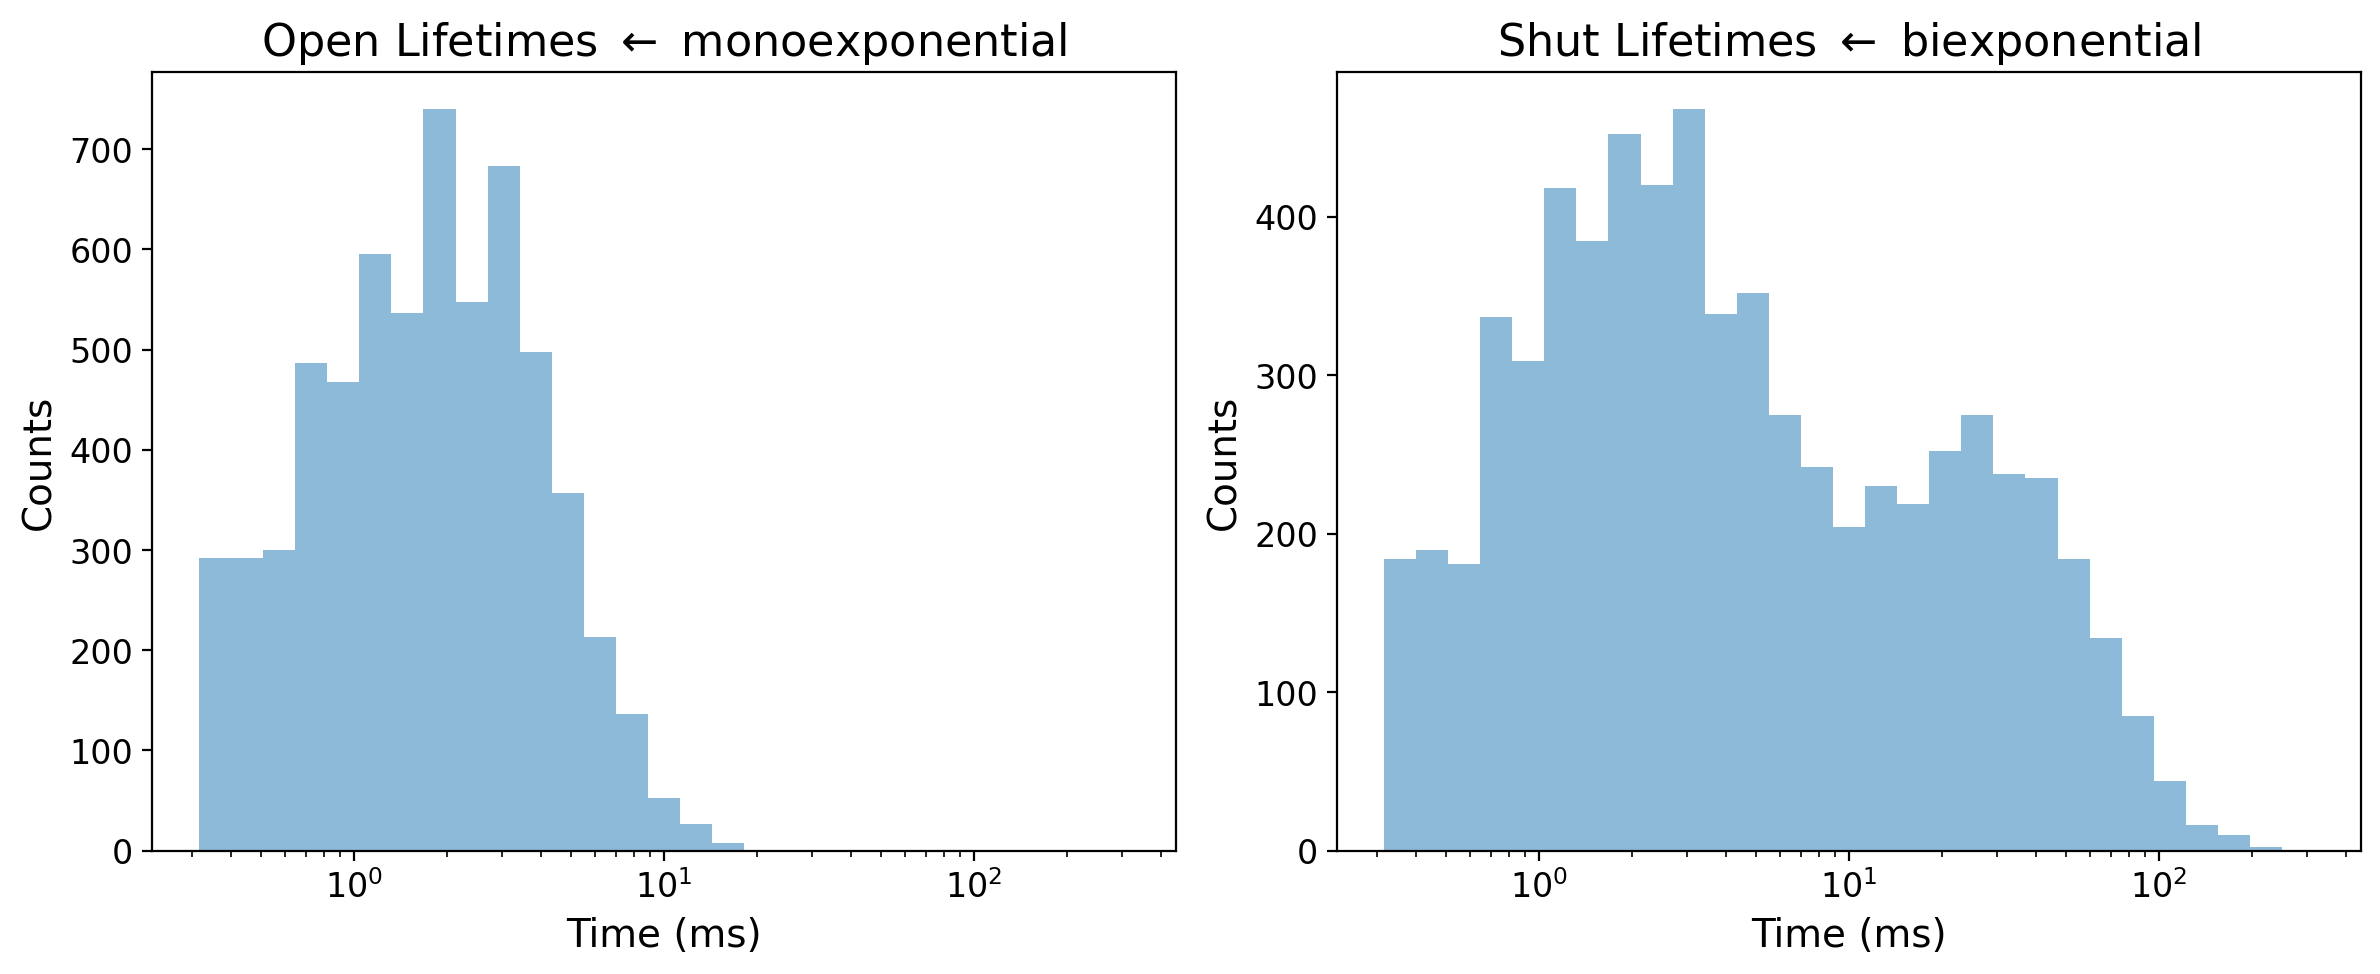

In [56]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)
binedges = np.logspace(-0.5, 2.5, 30)
plt.hist(open_times_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title(r'Open Lifetimes $\leftarrow$ monoexponential')
plt.xscale('log')

plt.subplot(1, 2, 2)
binedges = np.logspace(-0.5, 2.5, 30)
plt.hist(closed_times_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title(r'Shut Lifetimes $\leftarrow$ biexponential')
plt.xscale('log')
plt.tight_layout();

Consider the following observed sequence. For example, this could be the current from a single ion channel with multiple conductance states.

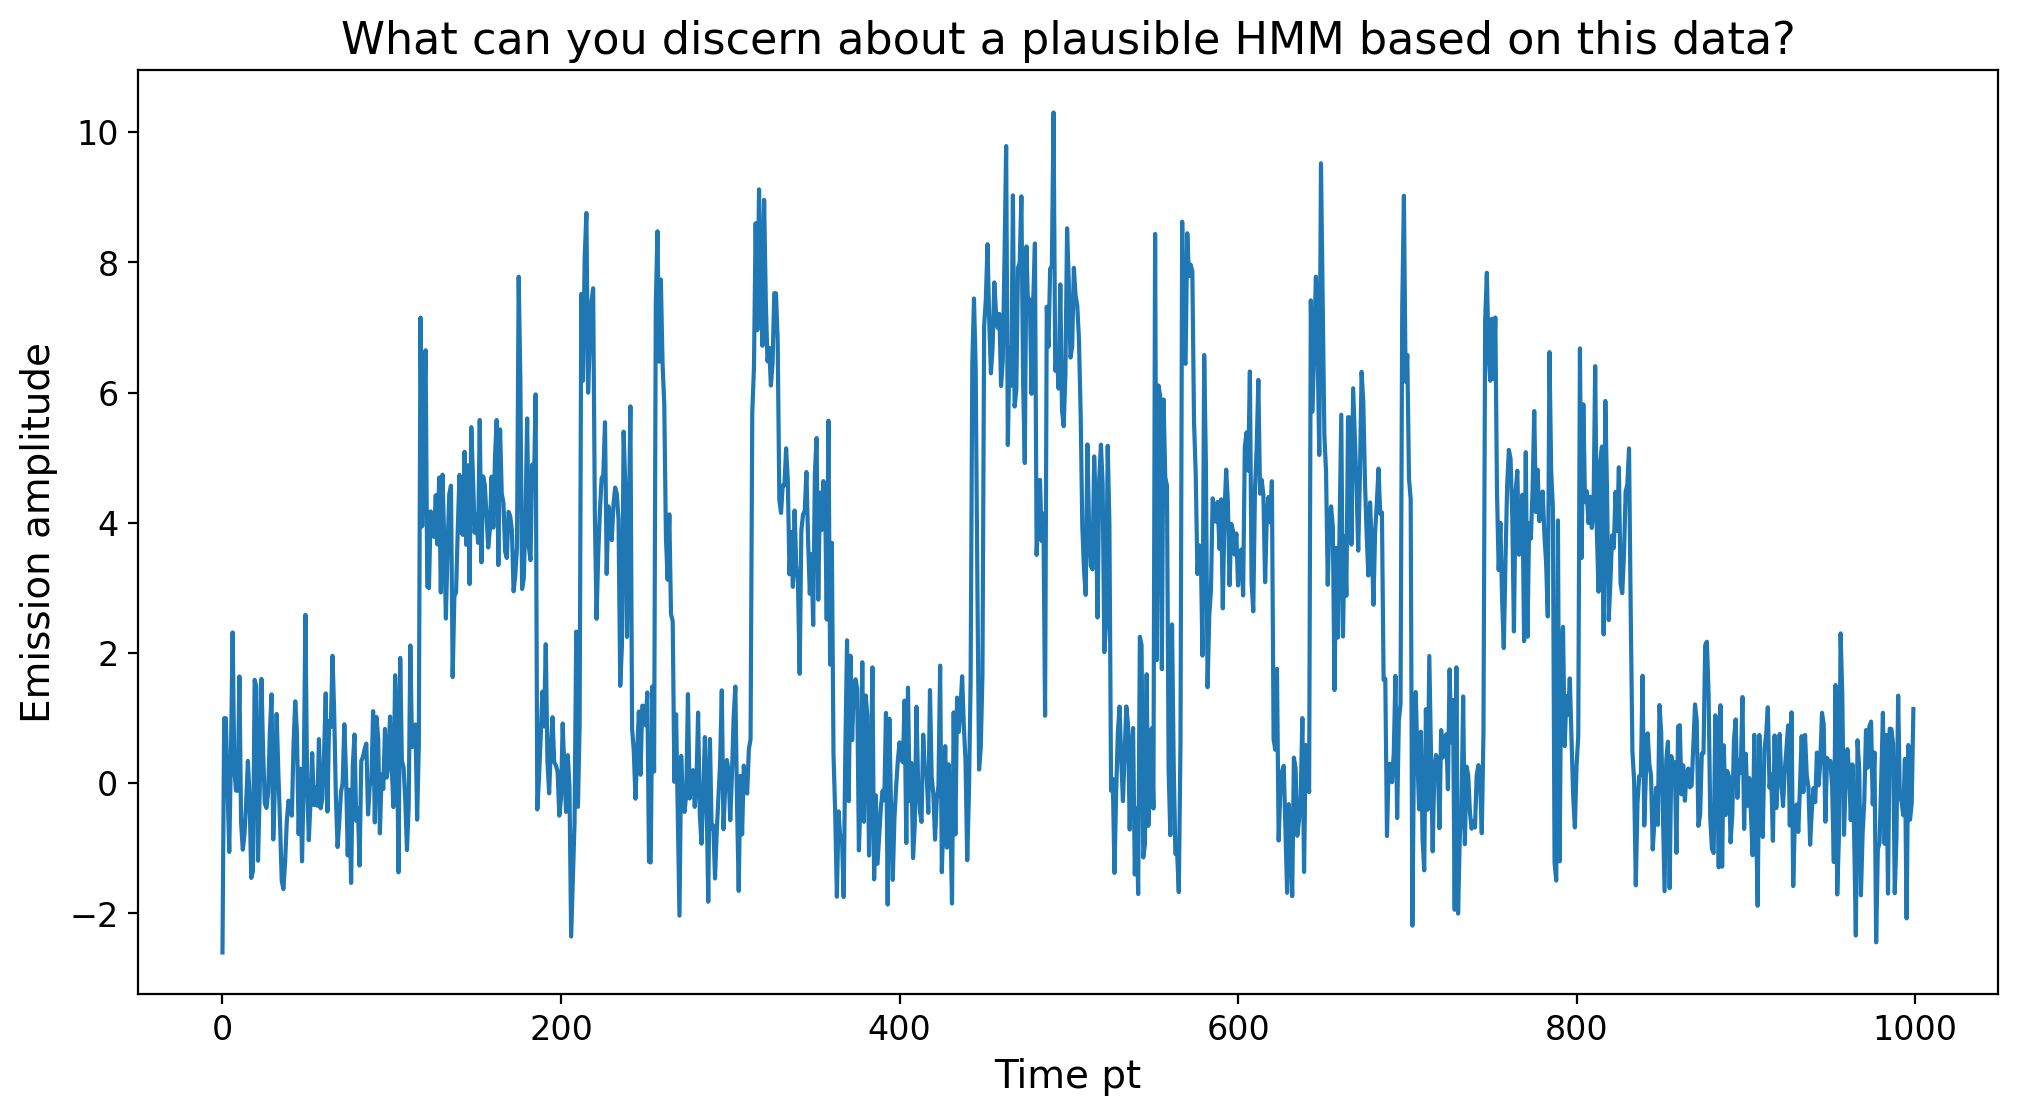

In [57]:
data_seq = np.load('data/observation-sequence.npy')

plt.plot(data_seq[:1000])
plt.xlabel('Time pt')
plt.ylabel('Emission amplitude')
plt.title('What can you discern about a plausible HMM based on this data?');

### Exercise
Look at the data sequence above.

1. Postulate an HMM (i.e., states and allowed transitions) that might explain this data.
2. Use pomegranate to optimize the HMM parameters for the observed seqeunce.
3. Visualize the most likely hidden state seqeunce. 

In [58]:
# # 1. state distributions...
# ...
# states = ...

# # 2. transition probabilities...
# edges = ...

# # 3. HMM...
# hmm = ...

# # 4. fit the HMM to the data sequence (first 10,000 data points to save time)...
# X = data_seq[:10000].reshape(1, -1, 1)
# ...

# # 5. HMM-predicted hidden state sequence...
# state_seq = ...

# # We'll visualize the state sequence in the next cell...

### Exercise key
Look at the data sequence above.

1. Postulate an HMM (i.e., states and allowed transitions) that might explain this data.
2. Use pomegranate to optimize the HMM parameters for the observed seqeunce.
3. Visualize the most likely hidden state seqeunce. 

In [59]:
# 1. state distributions...
S0 = Normal(means=[0.0], covs=[[1.0]])
S4 = Normal(means=[4.0], covs=[[1.0]])
S7 = Normal(means=[7.0], covs=[[1.0]])
states = [S0, S4, S7]

# 2. transition probabilities...
edges = [
    [0.9, 0.0, 0.1],  # 0->0, 0->4, 0->7
    [0.1, 0.9, 0.0],  # 4->0, 4->4, 4->7
    [0.0, 0.1, 0.9],  # 7->0, 7->4, 7->7
]

# 3. HMM...
hmm = DenseHMM(states, edges=edges)

# 4. fit the HMM to the data sequence (first 10,000 data points to save time)...
X = data_seq[:10000].reshape(1, -1, 1)
hmm.fit(X)

# 5. HMM-predicted hidden state sequence...
state_seq = hmm.predict(X)

# We'll visualize the state sequence in the next cell...

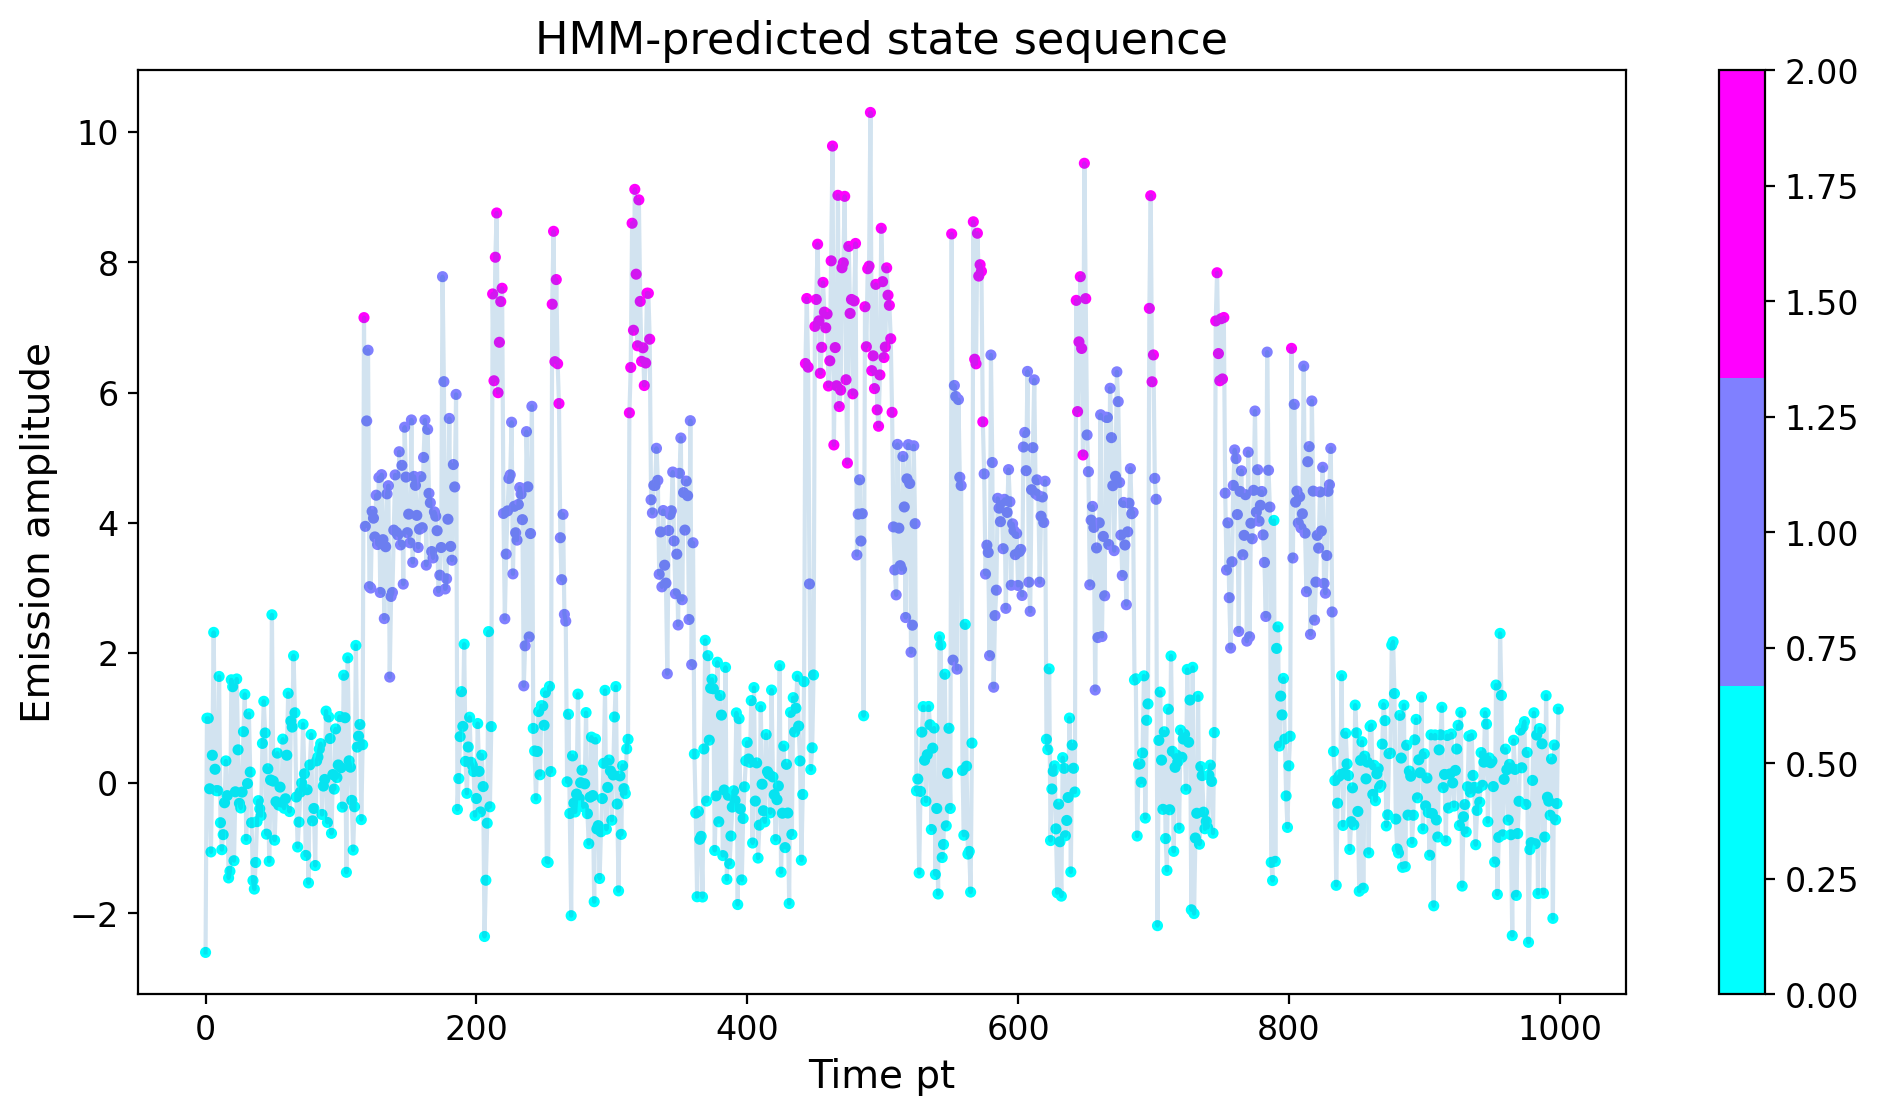

In [60]:
n = 1000
plt.plot(data_seq[:n], alpha=0.2)
plt.scatter(range(n), data_seq[:n], marker='.', c=state_seq[0,:n], cmap=cmap)
plt.xlabel('Time pt')
plt.ylabel('Emission amplitude')
plt.title('HMM-predicted state sequence')
plt.colorbar();

### Comparing multiple models

Consider the observed single ion channel data below (only the first few thaousand data points are shown).

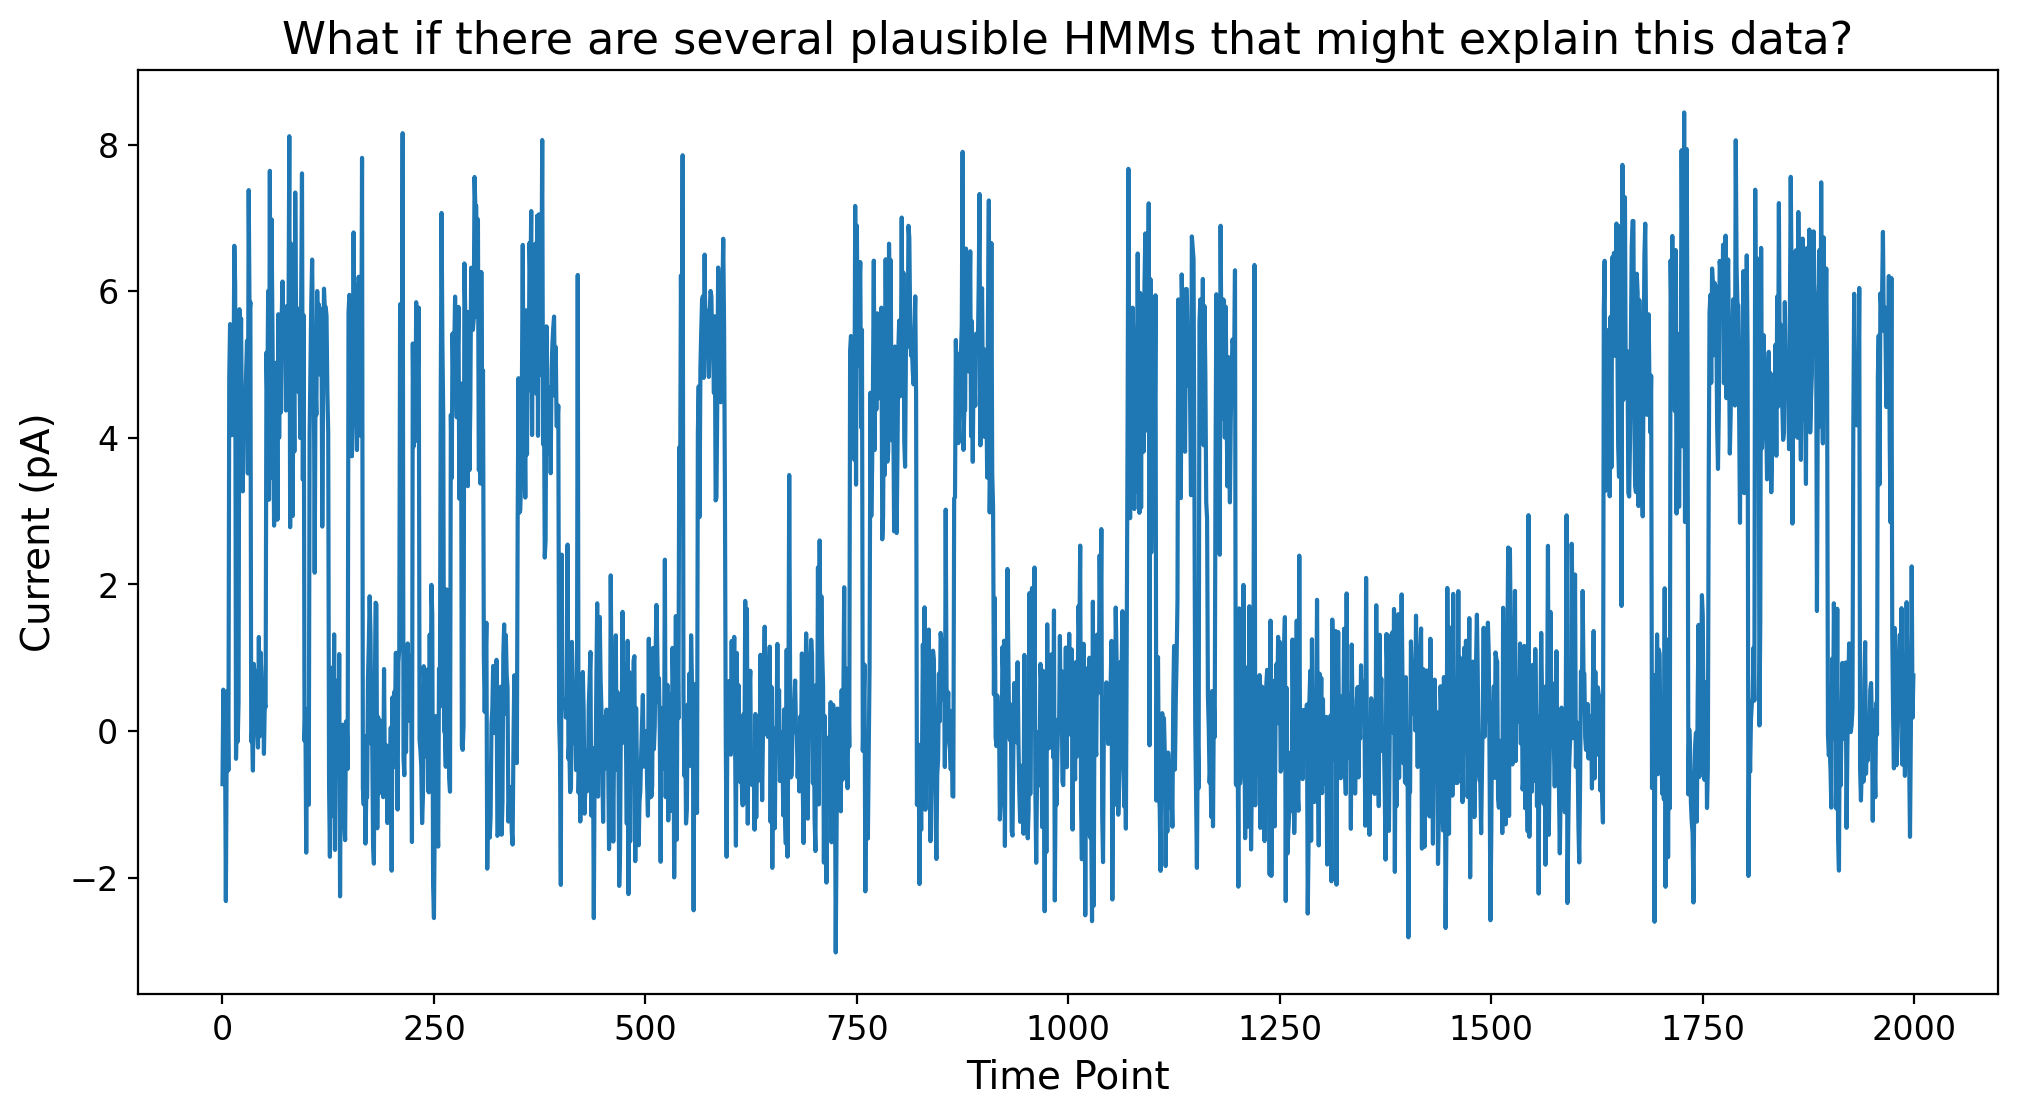

In [61]:
plt.plot(current_pA[:2000])
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('What if there are several plausible HMMs that might explain this data?');

Let's try the following potentially plausible HMMs:

`hmmCO`: Closed $\rightleftarrows$ Open

`hmmCCO`: Closed1 $\rightleftarrows$ Closed2 $\rightleftarrows$ Open

`hmmCOD`: Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized

`hmmOCOD`: Open1 $\rightleftarrows$ Closed $\rightleftarrows$ Open2 $\rightleftarrows$ Desensitized

`hmmCO`: Closed $\rightleftarrows$ Open

In [62]:
states = [
    Normal(means=[0.0], covs=[[1.0]]),
    Normal(means=[5.0], covs=[[1.0]]),
]

edges = [
    [0.9, 0.1],
    [0.1, 0.9],
]

hmmCO = DenseHMM(states, edges=edges)

`hmmCCO`: Closed1 $\rightleftarrows$ Closed2 $\rightleftarrows$ Open

In [63]:
states = [
    Normal(means=[0.0], covs=[[1.0]]),
    Normal(means=[0.0], covs=[[1.0]]),
    Normal(means=[5.0], covs=[[1.0]]),
]

edges = [
    [0.90, 0.10, 0.00],
    [0.05, 0.90, 0.05],
    [0.00, 0.10, 0.90],
]

hmmCCO = DenseHMM(states, edges=edges)

`hmmCOD`: Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized

In [64]:
states = [
    Normal(means=[0.0], covs=[[1.0]]),
    Normal(means=[5.0], covs=[[1.0]]),
    Normal(means=[0.0], covs=[[1.0]]),
]

edges = [
    [0.90, 0.10, 0.00],
    [0.05, 0.90, 0.05],
    [0.00, 0.01, 0.99],
]

hmmCOD = DenseHMM(states, edges=edges)

`hmmOCOD`: Open1 $\rightleftarrows$ Closed $\rightleftarrows$ Open2 $\rightleftarrows$ Desensitized

In [65]:
states = [
    Normal(means=[5.0], covs=[[1.0]]),
    Normal(means=[0.0], covs=[[1.0]]),
    Normal(means=[5.0], covs=[[1.0]]),
    Normal(means=[0.0], covs=[[1.0]]),
]

edges = [
    [0.90, 0.10, 0.00, 0.00],
    [0.05, 0.90, 0.05, 0.00],
    [0.00, 0.05, 0.90, 0.05],
    [0.00, 0.00, 0.01, 0.99],
]

hmmOCOD = DenseHMM(states, edges=edges)

Optimize all models for our ion channel current recording.

In [66]:
X = current_pA.reshape(1, -1, 1)

for hmm in [hmmCO, hmmCCO, hmmCOD, hmmOCOD]:
    hmm.fit(X)

Get the most likely state sequence according to each model.

In [67]:
state_seq_CO = hmmCO.predict(X)
state_seq_CCO = hmmCCO.predict(X)
state_seq_COD = hmmCOD.predict(X)
state_seq_OCOD = hmmOCOD.predict(X)

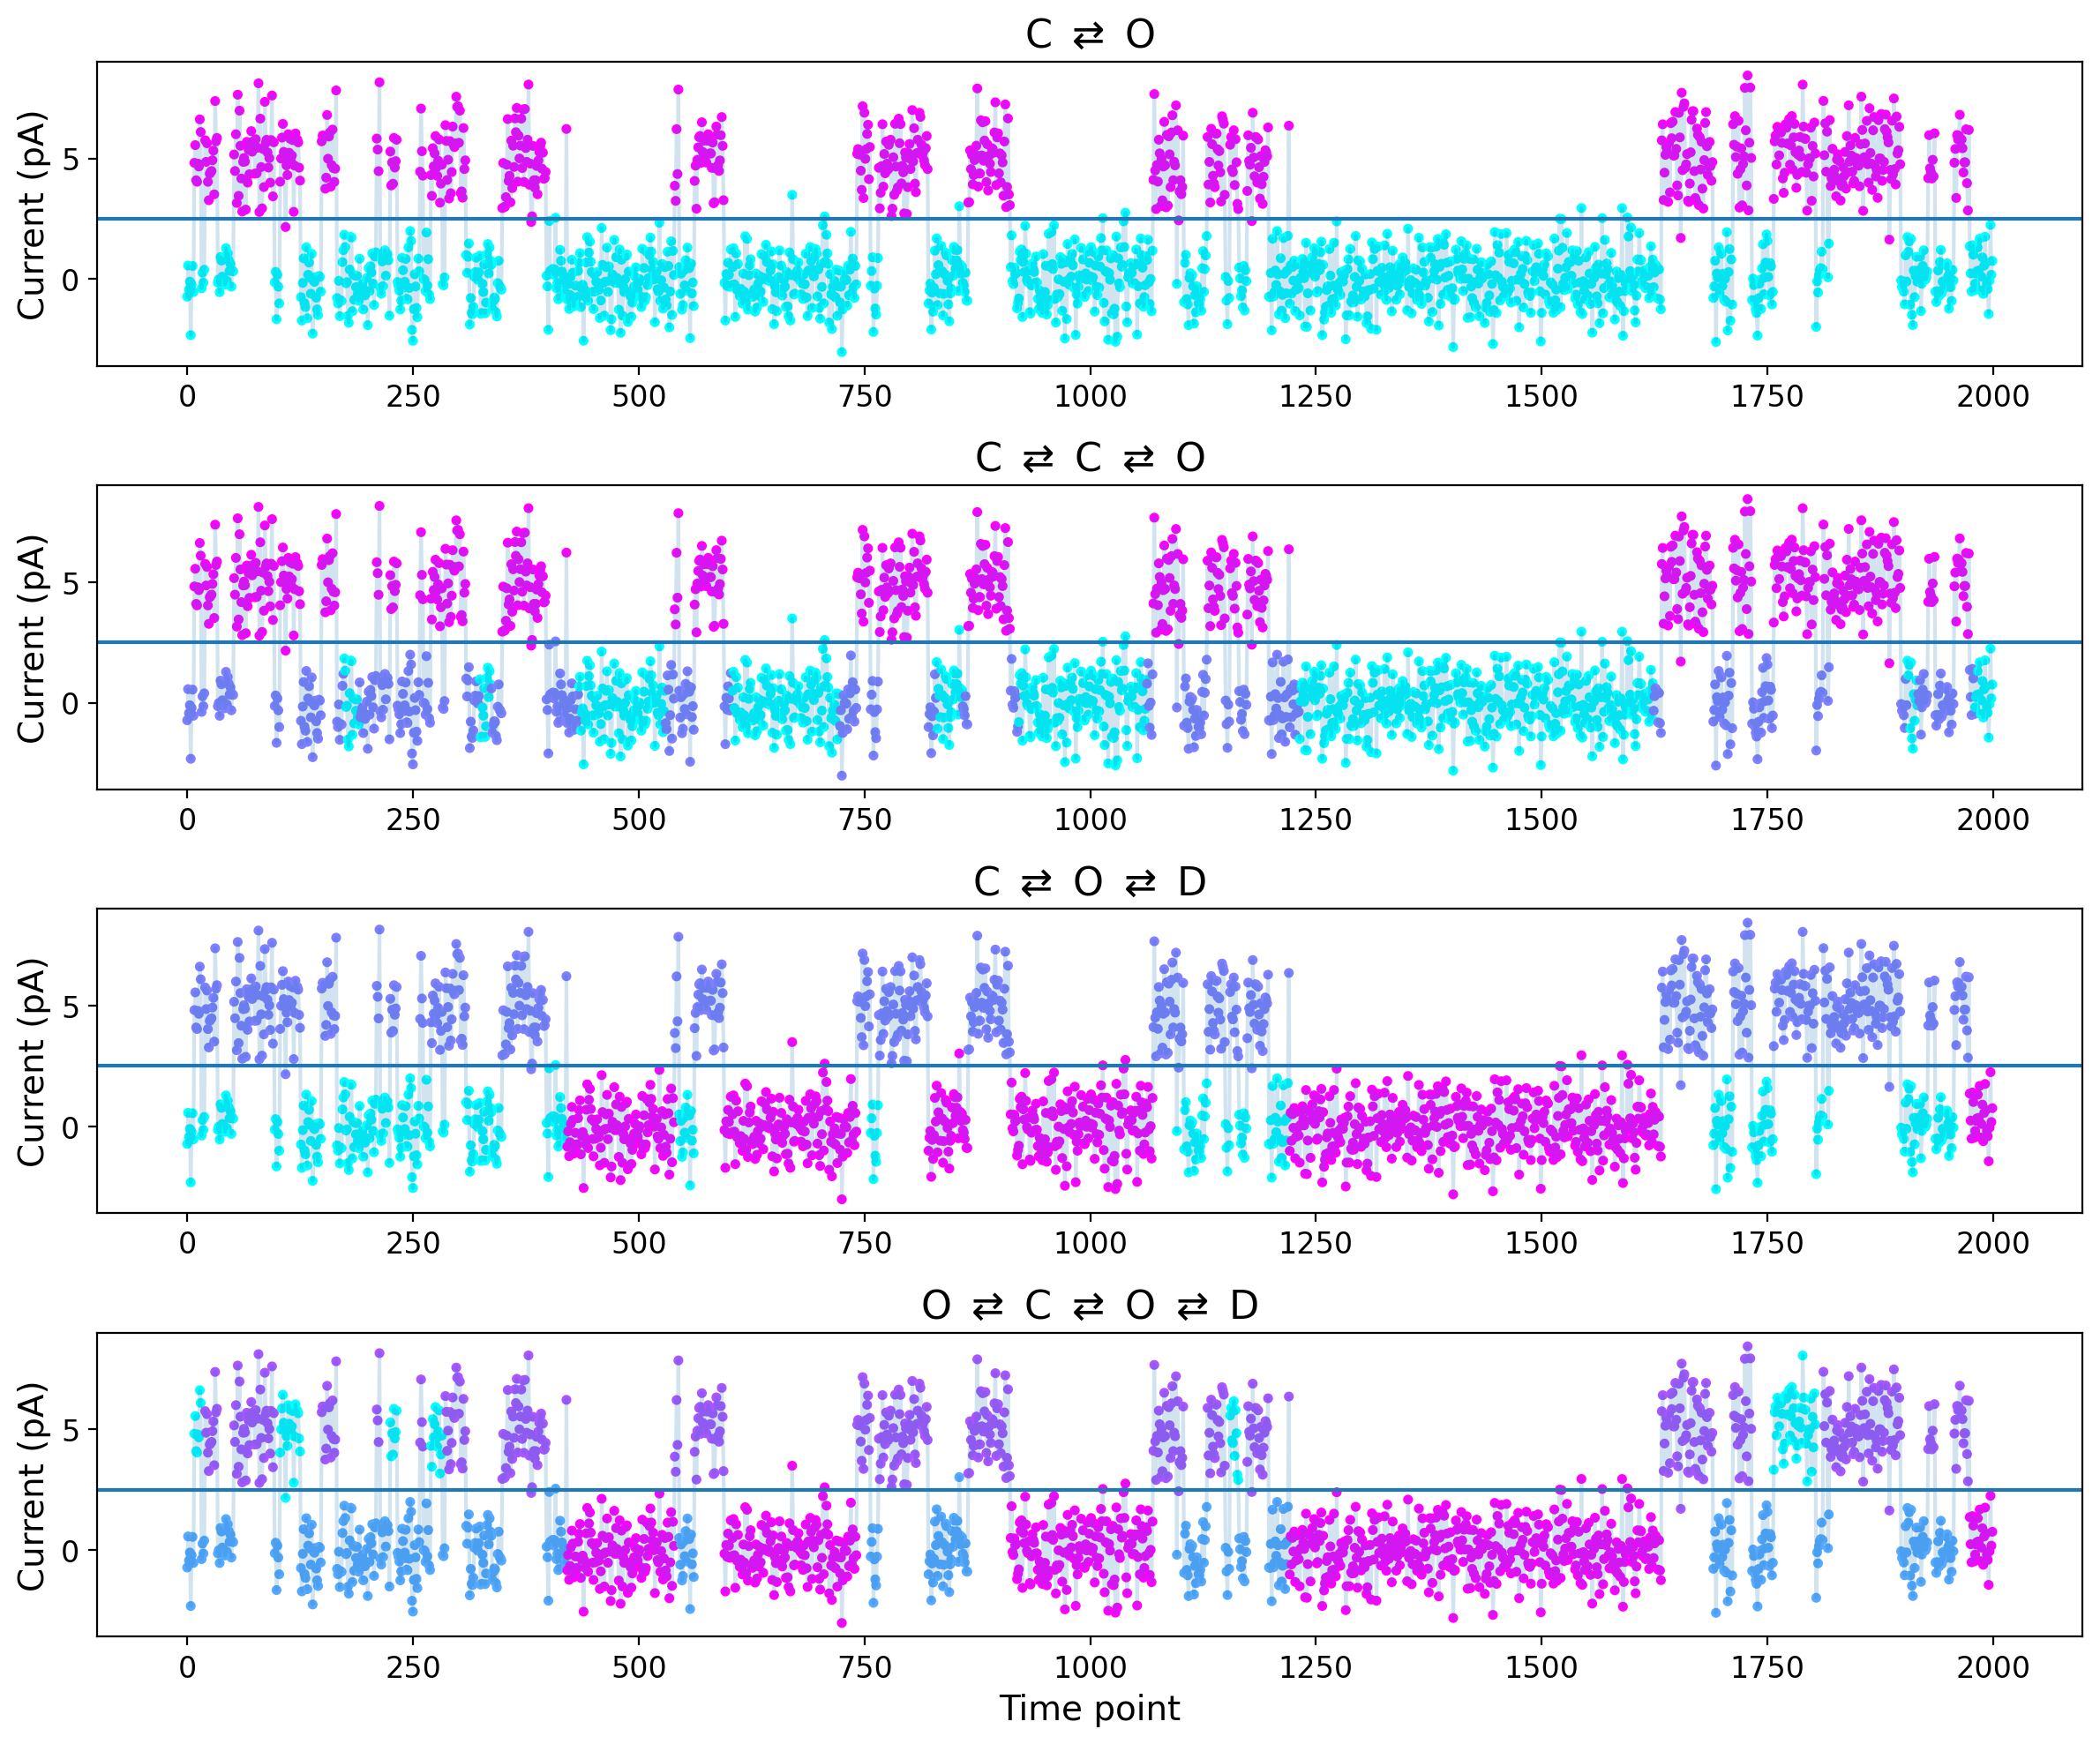

In [68]:
plt.figure(figsize=(12,10))
n = 2000
plt.subplot(4, 1, 1)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=state_seq_CO[0,:n], cmap='cool')
plt.ylabel('Current (pA)')
plt.title(r'C $\rightleftarrows$ O')

plt.subplot(4, 1, 2)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=state_seq_CCO[0,:n], cmap='cool')
plt.ylabel('Current (pA)')
plt.title(r'C $\rightleftarrows$ C $\rightleftarrows$ O')

plt.subplot(4, 1, 3)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=state_seq_COD[0,:n], cmap='cool')
plt.ylabel('Current (pA)')
plt.title(r'C $\rightleftarrows$ O $\rightleftarrows$ D')

plt.subplot(4, 1, 4)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=state_seq_OCOD[0,:n], cmap='cool')
plt.xlabel('Time point')
plt.ylabel('Current (pA)')
plt.title(r'O $\rightleftarrows$ C $\rightleftarrows$ O $\rightleftarrows$ D')
plt.tight_layout();

What is the (log)likelihood that each model describes the current recording?

In [69]:
LL_CO = hmmCO.log_probability(X)
LL_CCO = hmmCCO.log_probability(X)
LL_COD = hmmCOD.log_probability(X)
LL_OCOD = hmmOCOD.log_probability(X)

LL_CO, LL_CCO, LL_COD, LL_OCOD

(tensor([-15428.8203]),
 tensor([-15410.1201]),
 tensor([-15390.4463]),
 tensor([-15389.7900]))

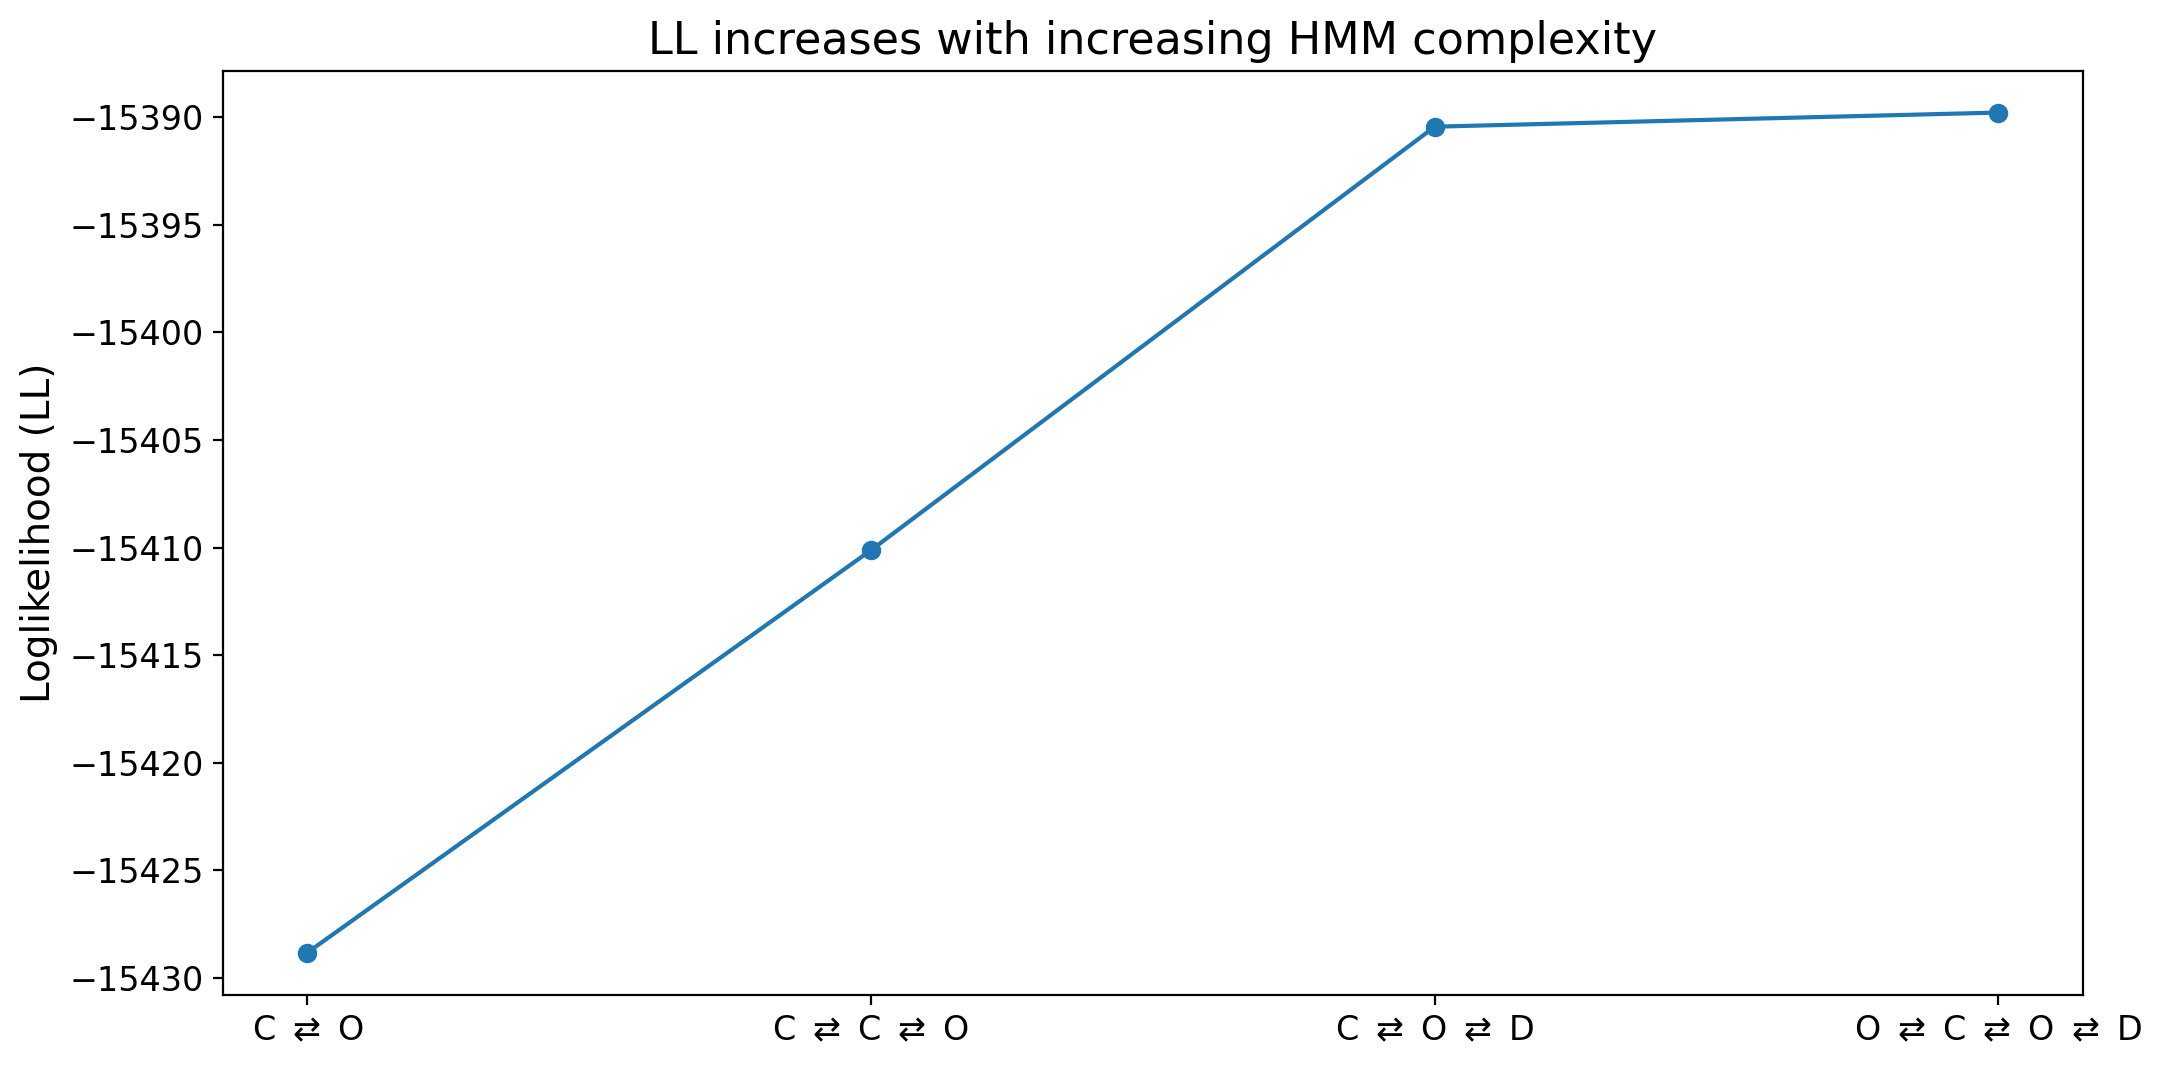

In [70]:
hmms = [
    r'C $\rightleftarrows$ O',
    r'C $\rightleftarrows$ C $\rightleftarrows$ O',
    r'C $\rightleftarrows$ O $\rightleftarrows$ D',
    r'O $\rightleftarrows$ C $\rightleftarrows$ O $\rightleftarrows$ D'
]
plt.plot(hmms, [LL_CO, LL_CCO, LL_COD, LL_OCOD], 'o-')
plt.ylabel('Loglikelihood (LL)')
plt.title('LL increases with increasing HMM complexity');

Model OCOD has more parameters than model COD, so of course it will fit the data better.

But should we prefer it?

Is it overfitting the data?

### Bayesian Information Criterion (BIC)

Anytime we can compute a log(likelihood) for a model, we can use BIC (or other empirical metrics) to select a model that balances complexity with goodness of fit.

$BIC = k * ln(n) - 2 * LL$

* $k$ = # of free parameters
* $n$ = # of data points
* $LL$ = loglikelihood

In [71]:
n = len(current_pA)

BIC_CO = 6 * np.log(n) - 2 * LL_CO
BIC_CCO = 10 * np.log(n) - 2 * LL_CCO
BIC_COD = 10 * np.log(n) - 2 * LL_COD
BIC_OCOD = 14 * np.log(n) - 2 * LL_OCOD

np.array([BIC_CO, BIC_CCO, BIC_COD, BIC_OCOD])

array([[30912.902],
       [30912.344],
       [30872.996],
       [30908.525]], dtype=float32)

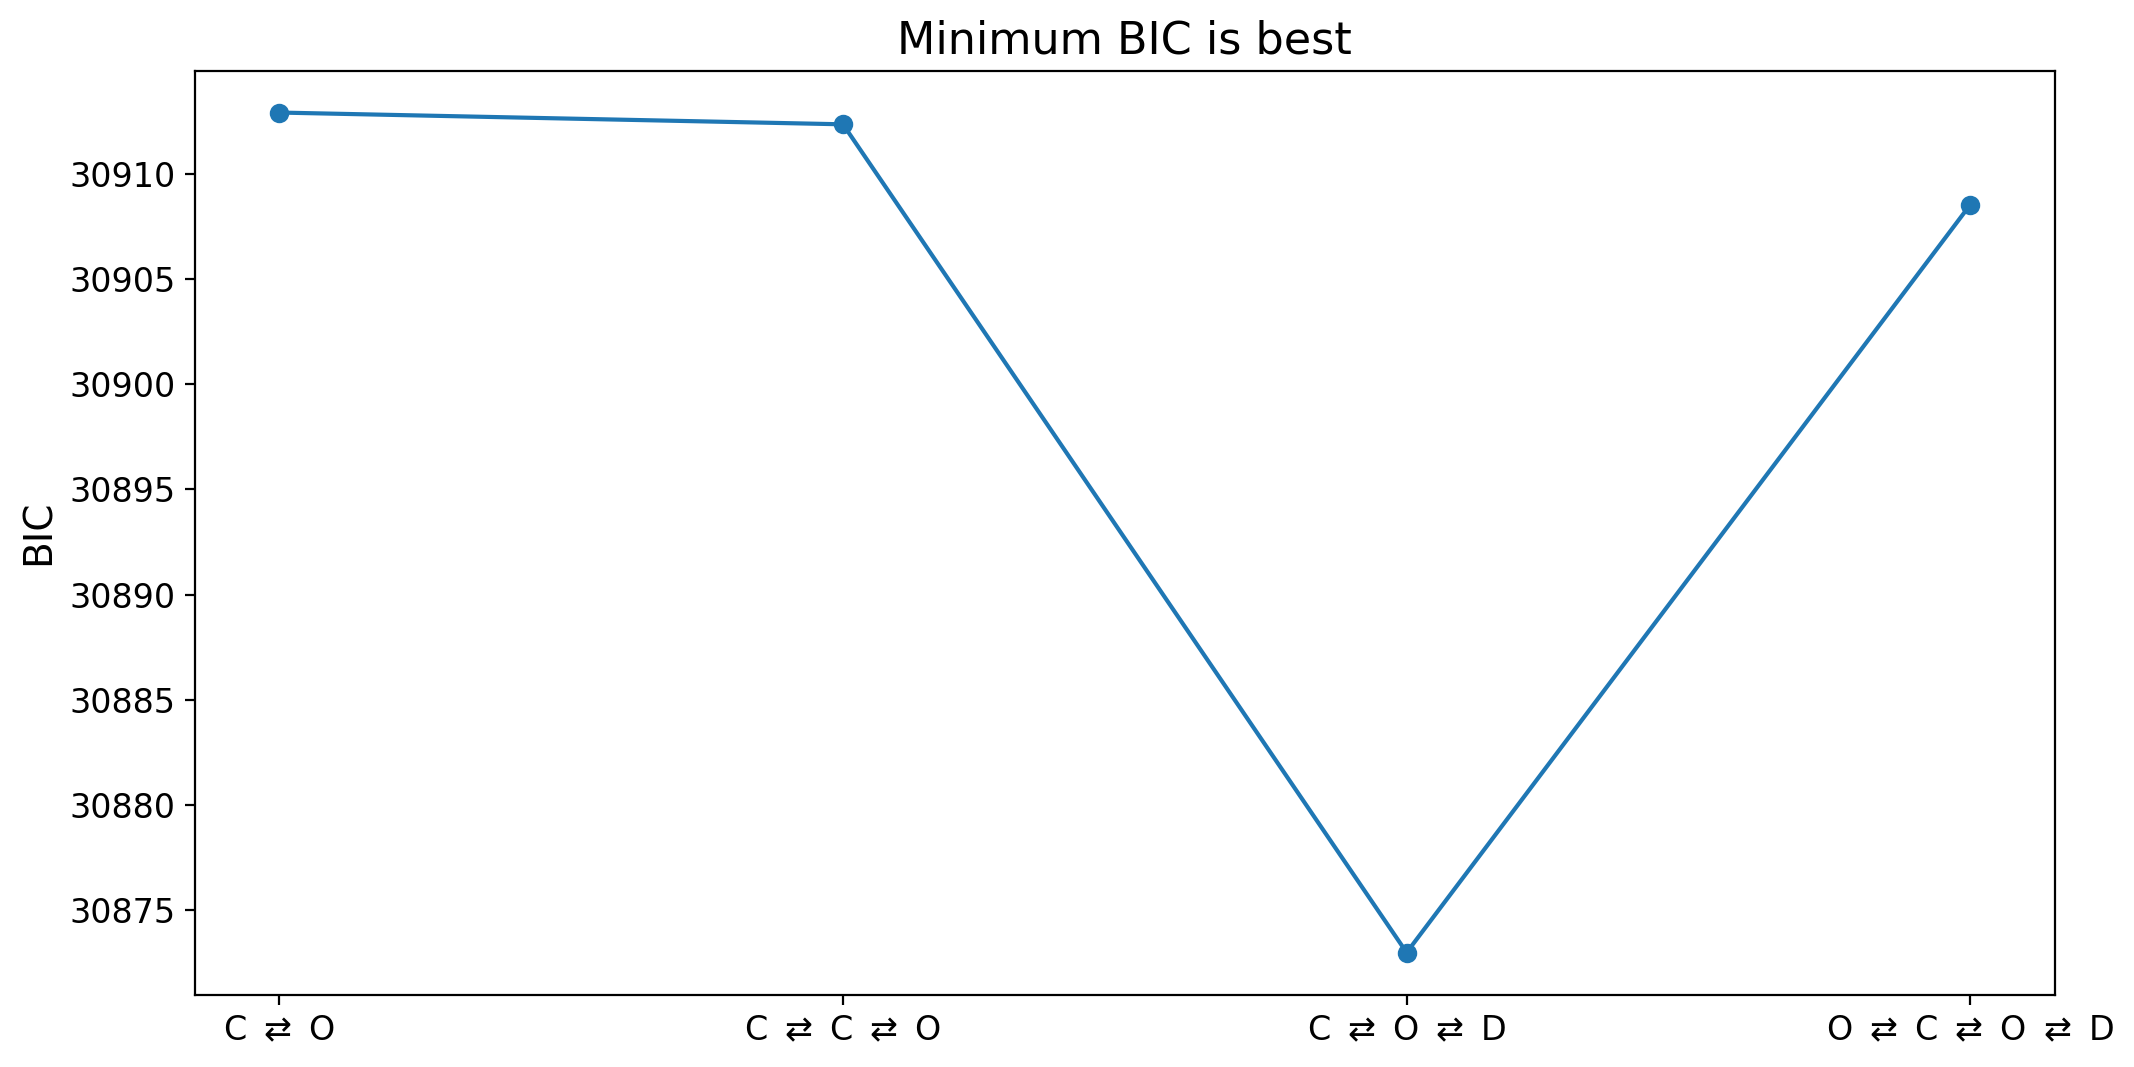

In [72]:
plt.plot(hmms, [BIC_CO, BIC_CCO, BIC_COD, BIC_OCOD], 'o-')
plt.ylabel('BIC')
plt.title('Minimum BIC is best');

# HMMs for other types of sequences (e.g., DNA)

How might you identify a gene in an unknown DNA sequence?

![](images/find-gene.png)

What about identifying the various parts (e.g., exons/introns) of a gene?

![](images/gene.png)

A very (overly) simple HMM for identifying exons and introns within a gene.

![Exon Intron HMM](images/exon-intron-gene-hmm.jpg)

 doi: 10.2174/138920209789177575

The model states are:
- **exon1**: 1st nucleotide in residue
- **exon2**: 2nd nucleotide in residue
- **exon3**: 3rd nucleotide in residue
- **intron**: nucleotide in intron

In [73]:
from pomegranate.distributions import Categorical

# Each nucleotide can be one of: A, C, G, T
# In an exon, we postulate that A, C, G, and T occur with equal probability.
# In an intron, we postulate that A and T are more likely.
exon1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
exon2 = Categorical([[0.25, 0.25, 0.25, 0.25]])
exon3 = Categorical([[0.25, 0.25, 0.25, 0.25]])
intron = Categorical([[0.4, 0.1, 0.1, 0.4]])

hmm = DenseHMM([exon1, exon2, exon3, intron])

Now define the allowable transitions in the model.

In [74]:
# gene always starts with an exon
hmm.add_edge(hmm.start, exon1, 1)

# if in an exon, read three nucleotides (one residue)
hmm.add_edge(exon1, exon2, 1)
hmm.add_edge(exon2, exon3, 1)

# following a residue there is either the next reside or an intron
hmm.add_edge(exon3, exon1, 0.9)
hmm.add_edge(exon3, intron, 0.09)

# gene always ends on an exon
hmm.add_edge(exon3, hmm.end, 0.01)

# if in an intron, either stay there or go to the next exon
hmm.add_edge(intron, intron, 0.9)
hmm.add_edge(intron, exon1, 0.1)

Based on the above HMM, what is the most likely sequence of hidden states that would give rise to the following sequence of observed nucleotides?

In [75]:
sequence = 'AAAATTGACTTATAATATTATAACAACTCTCCAGTGAGTGGATGAAACTCGGCTATGCATTGGTTGAATGGCGCTCAGAAGTTCGATGTTTGACTCCACTGCCATC'

In [76]:
X = np.array([['A', 'C', 'G', 'T'].index(char) for char in sequence]).reshape(1, -1, 1)
X.shape

(1, 106, 1)

In [77]:
X[0,:9]

array([[0],
       [0],
       [0],
       [0],
       [3],
       [3],
       [2],
       [0],
       [1]])

In [78]:
states = hmm.predict(X)
states

tensor([[0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
         2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
         2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
         2, 0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [79]:
print(sequence)
print(''.join([str(s) for s in states.numpy().squeeze()]))

AAAATTGACTTATAATATTATAACAACTCTCCAGTGAGTGGATGAAACTCGGCTATGCATTGGTTGAATGGCGCTCAGAAGTTCGATGTTTGACTCCACTGCCATC
0120120123333333333333333012012012012012012012012012012012012012012012012012012012012012012012012012012012


### Exercise
Use the above model to identify the exon and introns in the following sequence `seq`.

In [80]:
seq = 'TCCACCTGAGGGTAAAGAACCGTCTGCACTAGGTTATTCACATTGGATGCATTTGAAGATCAAATAAGTTCTAATCCG'

In [81]:
# # 1. input sequence data...
# X = np.array([['A', 'C', 'G', 'T'].index(char) for char in seq]).reshape(1, -1, 1)

# # 2. predicted hidden state sequence...
# states = ...

# print(seq)
# print(''.join([str(s) for s in states.numpy().squeeze()]))

### Exercise key

Use the above model to identify the exon and introns in the following sequence `seq`.

In [82]:
seq = 'TCCACCTGAGGGTAAAGAACCGTCTGCACTAGGTTATTCACATTGGATGCATTTGAAGATCAAATAAGTTCTAATCCG'

In [83]:
# 1. input sequence data...
X = np.array([['A', 'C', 'G', 'T'].index(char) for char in seq]).reshape(1, -1, 1)

# 2. predicted hidden state sequence...
states = hmm.predict(X)

print(seq)
print(''.join([str(s) for s in states.numpy().squeeze()]))

TCCACCTGAGGGTAAAGAACCGTCTGCACTAGGTTATTCACATTGGATGCATTTGAAGATCAAATAAGTTCTAATCCG
012012012012012012012012012012012012012012012012012333333333333333333012012012


But we just made up some nucleotide probabilities for exons and introns and transition probabilites between exons and introns.

Now let's fit the model to the sequence so that the model can learn more appropriate probabilities based on the data.

In [84]:
hmm.fit(X)

DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0-3): 4 x Categorical()
  )
)

The optimized transition probabilities amongst states...

In [85]:
np.exp(hmm.edges)

tensor([[0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.8244, 0.0000, 0.0000, 0.1273],
        [0.1648, 0.0000, 0.0000, 0.8352]])

The optimized nucleotide probabilities in each state...

In [86]:
import pandas as pd

probs = np.vstack([
    exon1.probs,
    exon2.probs,
    exon3.probs,
    intron.probs
])
pd.DataFrame(probs, index=['exon1', 'exon2', 'exon3', 'intron'], columns=['A', 'C', 'G', 'T'])

A         C         G         T
exon1   0.400429  0.049961  0.130606  0.419005
exon2   0.071344  0.330439  0.417624  0.180592
exon3   0.374782  0.325291  0.153052  0.146875
intron  0.406788  0.088181  0.093891  0.411140

Now get the new state predictions from the trained model.

In [87]:
states = hmm.predict(X)

print(seq)
print(''.join([str(s) for s in states.numpy().squeeze()]))

TCCACCTGAGGGTAAAGAACCGTCTGCACTAGGTTATTCACATTGGATGCATTTGAAGATCAAATAAGTTCTAATCCG
012012012012012012012012012012012012012012330120120120120120123333333333333012


For the above optimization to be realistically useful, we likely need to train the model on a lot more data than the super short sequence we gave it.

In addition to increasing the length of the seqeunce, you can optimize an HMM based on multiple input sequences.

In [88]:
X1 = np.array([['A', 'C', 'G', 'T'].index(char) for char in sequence]).reshape(1, -1, 1)
X2 = np.array([['A', 'C', 'G', 'T'].index(char) for char in seq]).reshape(1, -1, 1)

X1.shape, X2.shape

((1, 106, 1), (1, 78, 1))

Ok, so this is probably still far too little data to reliably train the model on, but you get the idea...

In [89]:
hmm.fit([X1, X2])

DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0-3): 4 x Categorical()
  )
)

The optimized transition probabilities amongst states...

In [90]:
np.exp(hmm.edges)

tensor([[0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.8431, 0.0000, 0.0000, 0.1159],
        [0.1504, 0.0000, 0.0000, 0.8496]])

The optimized nucleotide probabilities in each state...

In [91]:
import pandas as pd

probs = np.vstack([
    exon1.probs,
    exon2.probs,
    exon3.probs,
    intron.probs
])
pd.DataFrame(probs, index=['exon1', 'exon2', 'exon3', 'intron'], columns=['A', 'C', 'G', 'T'])

A         C         G         T
exon1   0.410734  0.071581  0.201452  0.316232
exon2   0.135493  0.293876  0.330069  0.240561
exon3   0.265506  0.296531  0.200603  0.237359
intron  0.409179  0.124906  0.060512  0.405403

Now get the new state predictions from the trained model.

In [92]:
states1 = hmm.predict(X1)
states2 = hmm.predict(X2)

In [93]:
print(sequence)
print(''.join([str(s) for s in states1.numpy().squeeze()]))

AAAATTGACTTATAATATTATAACAACTCTCCAGTGAGTGGATGAAACTCGGCTATGCATTGGTTGAATGGCGCTCAGAAGTTCGATGTTTGACTCCACTGCCATC
0120120123333333333333333330120120120120120120120120123012012012012012012012012012012012012012012012012012


In [94]:
print(seq)
print(''.join([str(s) for s in states2.numpy().squeeze()]))

TCCACCTGAGGGTAAAGAACCGTCTGCACTAGGTTATTCACATTGGATGCATTTGAAGATCAAATAAGTTCTAATCCG
012012012012012012012012012012012012012333330120120120120120123333012012012012


### !!! HMMs are widely aplicable to understanding sequences.